In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

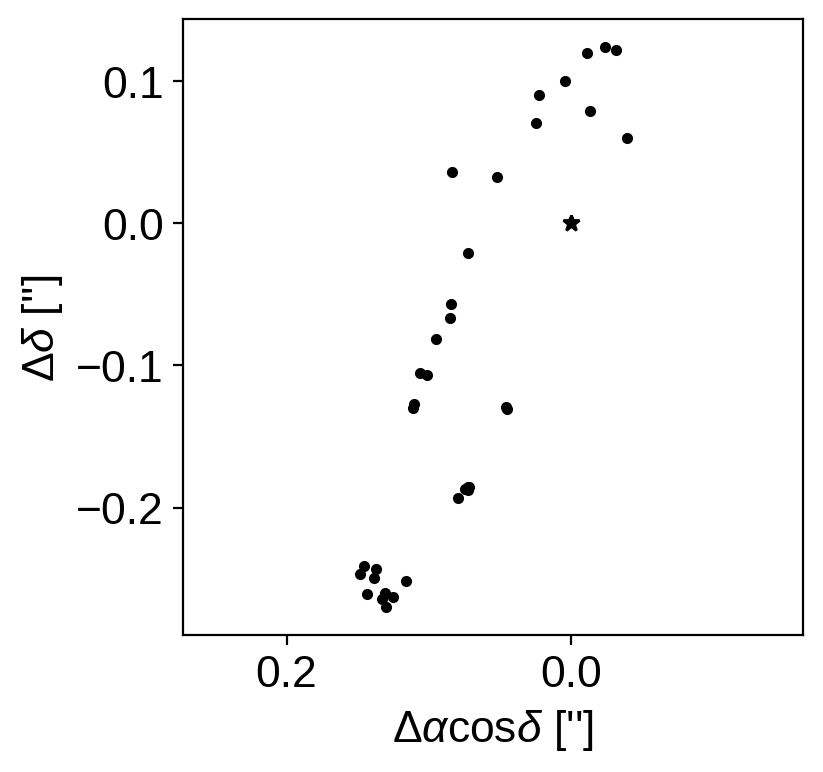

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

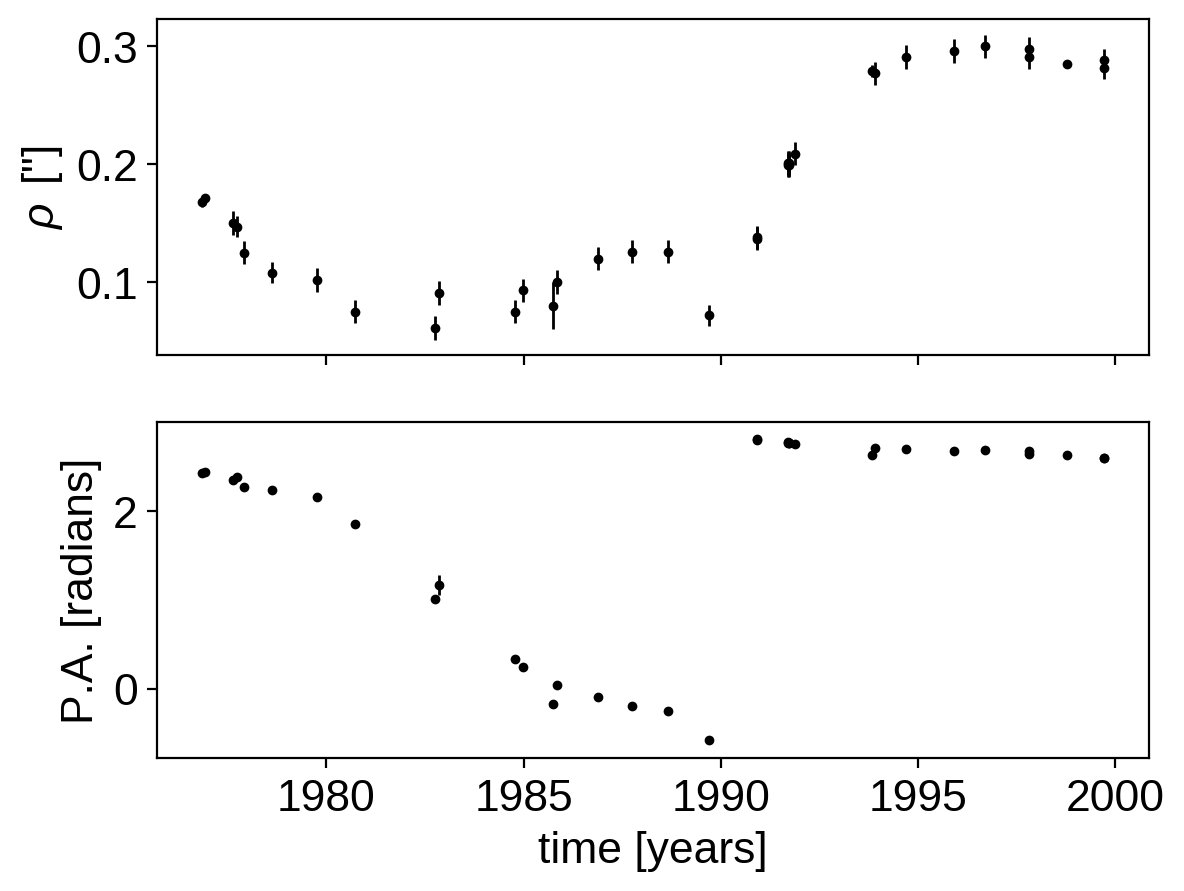

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

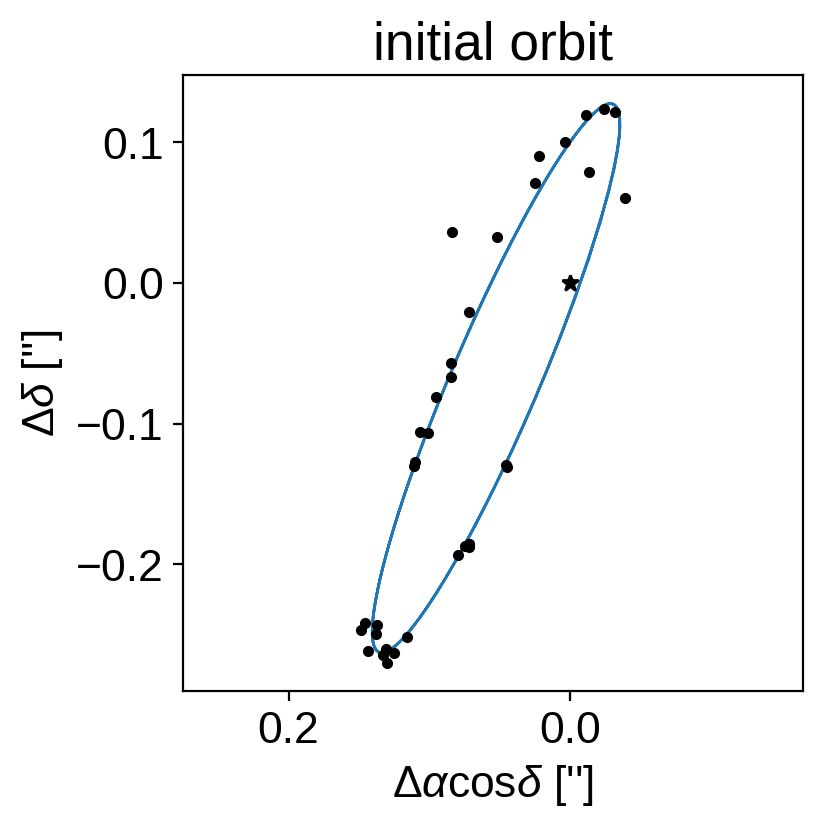

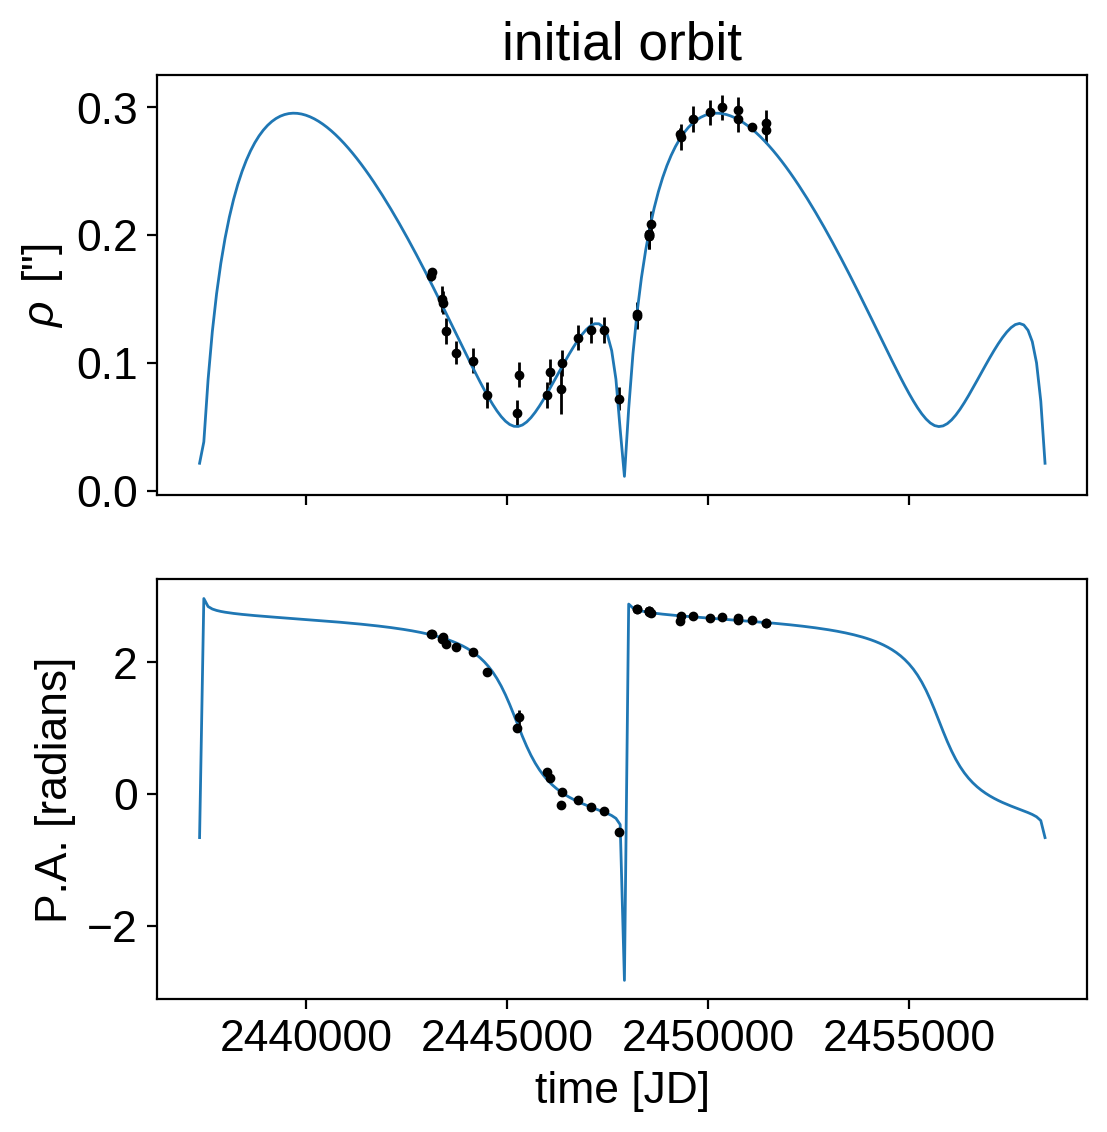

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 467.59it/s, logp=1.048555e+02]

2it [00:00, 576.06it/s, logp=1.448865e+02]

3it [00:00, 546.70it/s, logp=1.056457e+02]

4it [00:00, 569.22it/s, logp=1.457994e+02]

5it [00:00, 580.61it/s, logp=1.469999e+02]

6it [00:00, 585.85it/s, logp=1.471434e+02]

7it [00:00, 616.20it/s, logp=1.471440e+02]

8it [00:00, 633.88it/s, logp=1.471440e+02]

9it [00:00, 648.80it/s, logp=1.471440e+02]

10it [00:04,  2.42it/s, logp=1.471440e+02]


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 524.22it/s, logp=1.471440e+02]

2it [00:00, 645.38it/s, logp=-1.185831e+04]

3it [00:00, 706.75it/s, logp=1.471671e+02] 

4it [00:00, 683.64it/s, logp=1.472136e+02]

5it [00:00, 710.37it/s, logp=1.473986e+02]

6it [00:00, 737.03it/s, logp=1.481189e+02]

7it [00:00, 752.50it/s, logp=1.507231e+02]

8it [00:00, 729.51it/s, logp=1.565965e+02]

9it [00:00, 740.88it/s, logp=1.634911e+02]

10it [00:00, 685.24it/s, logp=1.666396e+02]

11it [00:00, 677.48it/s, logp=1.675455e+02]

12it [00:00, 691.67it/s, logp=1.676215e+02]

13it [00:00, 695.22it/s, logp=1.676248e+02]

14it [00:00, 695.56it/s, logp=1.676282e+02]

15it [00:00, 707.27it/s, logp=1.676337e+02]

16it [00:00, 709.01it/s, logp=1.676403e+02]

17it [00:00, 714.15it/s, logp=1.676419e+02]

18it [00:00, 720.05it/s, logp=1.676422e+02]

19it [00:00, 725.57it/s, logp=1.676422e+02]

20it [00:00, 715.62it/s, logp=1.676422e+02]

21it [00:00, 717.47it/s, logp=1.676422e+02]

22it [00:00, 27.99it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 392.58it/s, logp=1.676422e+02]

2it [00:00, 489.42it/s, logp=-4.521021e+03]

3it [00:00, 566.57it/s, logp=1.682354e+02] 

4it [00:00, 564.17it/s, logp=1.667490e+02]

5it [00:00, 602.54it/s, logp=1.683674e+02]

6it [00:00, 625.83it/s, logp=1.686220e+02]

7it [00:00, 653.83it/s, logp=1.694033e+02]

8it [00:00, 664.79it/s, logp=1.714304e+02]

9it [00:00, 689.00it/s, logp=1.784310e+02]

10it [00:00, 691.34it/s, logp=1.921973e+02]

11it [00:00, 695.23it/s, logp=1.936845e+02]

12it [00:00, 672.94it/s, logp=1.964254e+02]

13it [00:00, 674.88it/s, logp=2.010939e+02]

14it [00:00, 680.37it/s, logp=2.074741e+02]

15it [00:00, 688.34it/s, logp=2.094264e+02]

16it [00:00, 693.37it/s, logp=2.098562e+02]

17it [00:00, 693.71it/s, logp=2.098999e+02]

18it [00:00, 699.59it/s, logp=2.099152e+02]

19it [00:00, 691.32it/s, logp=2.099416e+02]

20it [00:00, 666.64it/s, logp=2.099853e+02]

21it [00:00, 672.06it/s, logp=2.100398e+02]

22it [00:00, 677.80it/s, logp=2.100552e+02]

23it [00:00, 669.95it/s, logp=2.100609e+02]

24it [00:00, 670.28it/s, logp=2.100614e+02]

25it [00:00, 672.23it/s, logp=2.100617e+02]

26it [00:00, 671.13it/s, logp=2.100622e+02]

27it [00:00, 670.12it/s, logp=2.100629e+02]

28it [00:00, 658.68it/s, logp=2.100633e+02]

29it [00:00, 661.16it/s, logp=2.100634e+02]

30it [00:00, 663.36it/s, logp=2.100634e+02]

31it [00:00, 662.14it/s, logp=2.100634e+02]

32it [00:00, 661.05it/s, logp=2.100634e+02]

33it [00:00, 662.69it/s, logp=2.100634e+02]

34it [00:00, 38.39it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297904


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 487.71it/s, logp=2.100634e+02]

2it [00:00, 548.06it/s, logp=-4.378171e+03]

3it [00:00, 633.58it/s, logp=2.102114e+02] 

4it [00:00, 638.52it/s, logp=2.103607e+02]

5it [00:00, 654.32it/s, logp=2.104883e+02]

6it [00:00, 668.77it/s, logp=2.105011e+02]

7it [00:00, 682.21it/s, logp=2.105011e+02]

8it [00:00, 712.39it/s, logp=2.105014e+02]

9it [00:00, 717.72it/s, logp=2.105014e+02]

10it [00:00, 728.54it/s, logp=2.105014e+02]

11it [00:01,  9.16it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.06340668297906 -> 210.50136989148027


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 417.01it/s, logp=2.105014e+02]

2it [00:00, 501.26it/s, logp=-4.041226e+03]

3it [00:00, 583.49it/s, logp=2.124628e+02] 

4it [00:00, 596.99it/s, logp=1.648448e+02]

5it [00:00, 635.10it/s, logp=2.125361e+02]

6it [00:00, 641.74it/s, logp=2.126469e+02]

7it [00:00, 645.01it/s, logp=2.128268e+02]

8it [00:00, 647.91it/s, logp=2.130889e+02]

9it [00:00, 640.24it/s, logp=2.132127e+02]

10it [00:00, 641.91it/s, logp=2.131910e+02]

11it [00:00, 648.75it/s, logp=2.132712e+02]

12it [00:00, 652.29it/s, logp=2.133790e+02]

13it [00:00, 664.52it/s, logp=2.135772e+02]

14it [00:00, 658.58it/s, logp=2.139432e+02]

15it [00:00, 662.76it/s, logp=2.145105e+02]

16it [00:00, 664.25it/s, logp=2.146599e+02]

17it [00:00, 666.62it/s, logp=2.148474e+02]

18it [00:00, 662.89it/s, logp=2.149170e+02]

19it [00:00, 667.37it/s, logp=2.149377e+02]

20it [00:00, 660.00it/s, logp=2.149628e+02]

21it [00:00, 662.96it/s, logp=2.149864e+02]

22it [00:00, 661.53it/s, logp=2.150041e+02]

23it [00:00, 667.55it/s, logp=2.150108e+02]

24it [00:00, 674.62it/s, logp=2.150182e+02]

25it [00:00, 681.19it/s, logp=2.150205e+02]

26it [00:00, 686.35it/s, logp=2.150210e+02]

27it [00:00, 680.62it/s, logp=2.150212e+02]

28it [00:00, 686.15it/s, logp=2.150212e+02]

29it [00:00, 677.67it/s, logp=2.150212e+02]

30it [00:00, 678.09it/s, logp=2.150212e+02]

31it [00:00, 672.47it/s, logp=2.150212e+02]

32it [00:00, 674.00it/s, logp=2.150212e+02]

33it [00:00, 678.18it/s, logp=2.150212e+02]

34it [00:00, 678.95it/s, logp=2.150212e+02]

35it [00:00, 42.85it/s, logp=2.150212e+02] 


message: Optimization terminated successfully.
logp: 210.5013698914803 -> 215.021177422116


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

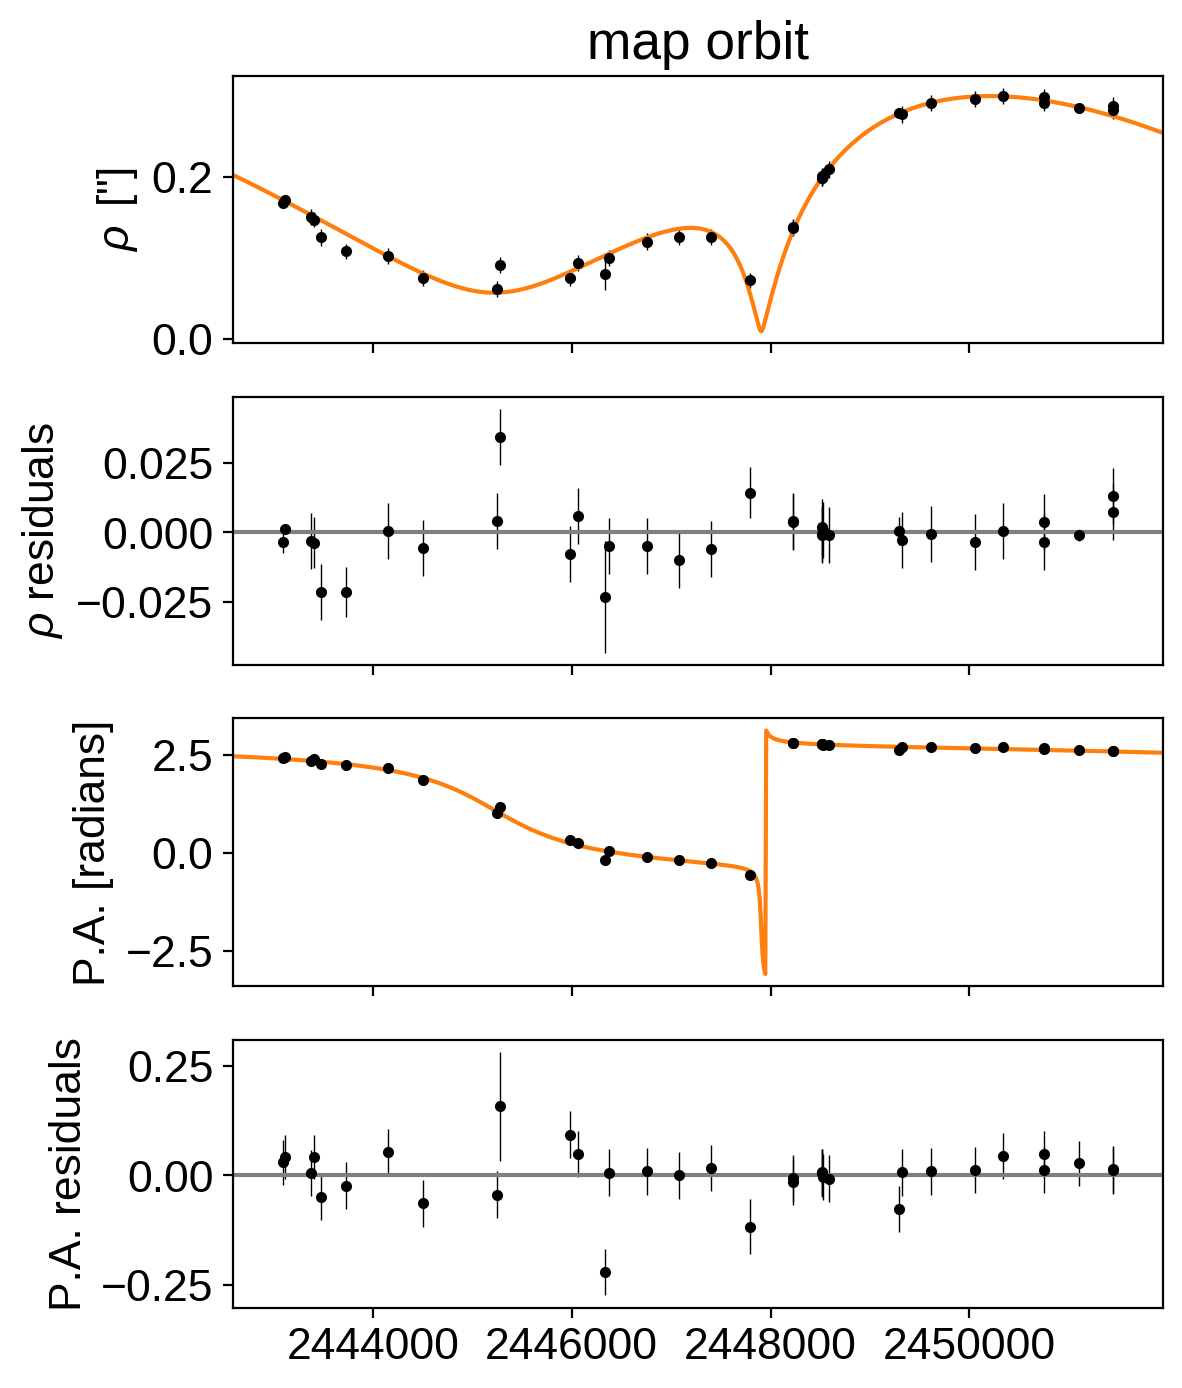

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<05:38, 53.23draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/18000 [00:00<08:34, 34.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/18000 [00:00<11:44, 25.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<14:15, 21.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<15:46, 19.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<16:44, 17.90draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<17:32, 17.08draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 22/18000 [00:01<16:12, 18.49draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 24/18000 [00:01<16:58, 17.65draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 26/18000 [00:01<18:00, 16.63draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 28/18000 [00:01<18:35, 16.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 30/18000 [00:01<18:55, 15.82draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<19:01, 15.74draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/18000 [00:01<18:11, 16.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/18000 [00:01<18:36, 16.09draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 39/18000 [00:02<17:56, 16.68draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 41/18000 [00:02<18:12, 16.43draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/18000 [00:02<16:53, 17.71draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/18000 [00:02<17:44, 16.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/18000 [00:02<16:22, 18.27draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/18000 [00:02<17:16, 17.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/18000 [00:02<17:41, 16.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/18000 [00:02<18:33, 16.12draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/18000 [00:03<19:06, 15.65draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 59/18000 [00:03<19:01, 15.72draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/18000 [00:03<19:00, 15.73draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 63/18000 [00:03<18:41, 16.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 65/18000 [00:03<18:38, 16.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 67/18000 [00:03<18:39, 16.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 69/18000 [00:03<18:49, 15.87draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 71/18000 [00:04<18:39, 16.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 73/18000 [00:04<18:48, 15.88draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/18000 [00:04<18:36, 16.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:04<16:48, 17.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 81/18000 [00:04<17:05, 17.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 85/18000 [00:04<14:21, 20.79draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 88/18000 [00:04<15:00, 19.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 92/18000 [00:04<12:54, 23.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 95/18000 [00:05<12:49, 23.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/18000 [00:05<14:37, 20.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 101/18000 [00:05<16:06, 18.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/18000 [00:05<15:07, 19.72draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 107/18000 [00:05<14:44, 20.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 110/18000 [00:05<17:34, 16.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/18000 [00:06<18:04, 16.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/18000 [00:06<17:12, 17.33draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 118/18000 [00:06<14:36, 20.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/18000 [00:06<14:05, 21.14draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 124/18000 [00:06<13:44, 21.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 127/18000 [00:06<13:27, 22.14draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/18000 [00:06<13:35, 21.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 133/18000 [00:06<13:09, 22.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/18000 [00:07<11:39, 25.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 141/18000 [00:07<11:54, 25.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 144/18000 [00:07<12:21, 24.08draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 147/18000 [00:07<14:12, 20.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 150/18000 [00:07<15:27, 19.24draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 154/18000 [00:07<14:02, 21.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 157/18000 [00:08<15:01, 19.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 160/18000 [00:08<14:36, 20.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/18000 [00:08<14:39, 20.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 166/18000 [00:08<16:53, 17.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 169/18000 [00:08<15:31, 19.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 172/18000 [00:08<17:17, 17.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 174/18000 [00:09<17:51, 16.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 176/18000 [00:09<17:51, 16.63draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/18000 [00:09<16:32, 17.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 181/18000 [00:09<17:37, 16.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 184/18000 [00:09<16:14, 18.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 186/18000 [00:09<15:59, 18.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 190/18000 [00:09<14:46, 20.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 193/18000 [00:09<14:25, 20.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 196/18000 [00:10<13:43, 21.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/18000 [00:10<14:36, 20.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 202/18000 [00:10<14:08, 20.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 205/18000 [00:10<14:20, 20.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 208/18000 [00:10<13:58, 21.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 211/18000 [00:10<15:10, 19.53draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 214/18000 [00:10<14:27, 20.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 217/18000 [00:11<15:52, 18.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 222/18000 [00:11<13:48, 21.45draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 225/18000 [00:11<15:28, 19.14draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 228/18000 [00:11<16:37, 17.82draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 230/18000 [00:11<17:08, 17.28draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 232/18000 [00:11<17:56, 16.51draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 235/18000 [00:12<16:52, 17.54draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 238/18000 [00:12<16:48, 17.62draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 240/18000 [00:12<16:28, 17.97draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 243/18000 [00:12<15:45, 18.78draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 245/18000 [00:12<16:15, 18.20draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 249/18000 [00:12<13:47, 21.45draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 253/18000 [00:12<11:57, 24.74draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 257/18000 [00:13<12:03, 24.52draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 260/18000 [00:13<12:17, 24.06draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 263/18000 [00:13<15:12, 19.44draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 266/18000 [00:13<14:57, 19.76draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 269/18000 [00:13<16:35, 17.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/18000 [00:13<16:57, 17.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 274/18000 [00:13<15:22, 19.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/18000 [00:14<16:03, 18.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 279/18000 [00:14<16:50, 17.54draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/18000 [00:14<16:38, 17.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 284/18000 [00:14<14:36, 20.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/18000 [00:14<15:09, 19.48draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 290/18000 [00:14<14:00, 21.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/18000 [00:14<14:08, 20.87draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 296/18000 [00:15<13:37, 21.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 300/18000 [00:15<13:05, 22.53draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 303/18000 [00:15<13:51, 21.27draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 306/18000 [00:15<13:55, 21.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 309/18000 [00:15<14:02, 20.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 312/18000 [00:15<15:12, 19.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 314/18000 [00:15<15:51, 18.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 317/18000 [00:16<15:06, 19.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 320/18000 [00:16<14:21, 20.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 323/18000 [00:16<14:29, 20.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 326/18000 [00:16<14:18, 20.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 329/18000 [00:16<14:38, 20.12draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 334/18000 [00:16<12:49, 22.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 337/18000 [00:16<12:18, 23.92draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 340/18000 [00:17<14:24, 20.44draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 343/18000 [00:17<14:44, 19.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 347/18000 [00:17<13:40, 21.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 350/18000 [00:17<15:18, 19.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 353/18000 [00:17<15:52, 18.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 355/18000 [00:17<16:36, 17.70draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 358/18000 [00:18<14:59, 19.62draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 361/18000 [00:18<14:13, 20.66draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 364/18000 [00:18<16:53, 17.41draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 368/18000 [00:18<15:26, 19.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 371/18000 [00:18<14:24, 20.39draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 374/18000 [00:18<14:14, 20.63draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/18000 [00:18<13:19, 22.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 380/18000 [00:19<13:13, 22.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 383/18000 [00:19<16:36, 17.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 386/18000 [00:19<16:36, 17.68draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 388/18000 [00:19<17:24, 16.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 391/18000 [00:19<17:51, 16.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 393/18000 [00:19<18:23, 15.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 395/18000 [00:20<22:34, 13.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 398/18000 [00:20<19:47, 14.82draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 400/18000 [00:20<19:36, 14.97draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 403/18000 [00:20<17:27, 16.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 407/18000 [00:20<14:57, 19.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 412/18000 [00:20<13:00, 22.53draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 415/18000 [00:20<13:13, 22.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 418/18000 [00:21<13:06, 22.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 422/18000 [00:21<11:34, 25.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 426/18000 [00:21<10:24, 28.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 433/18000 [00:21<08:35, 34.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 445/18000 [00:21<06:45, 43.34draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 455/18000 [00:21<05:39, 51.61draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 464/18000 [00:21<05:01, 58.21draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 475/18000 [00:21<04:23, 66.47draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 492/18000 [00:21<03:37, 80.62draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 506/18000 [00:22<03:10, 91.85draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 523/18000 [00:22<02:46, 104.89draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 542/18000 [00:22<02:24, 120.66draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 561/18000 [00:22<02:09, 134.85draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 580/18000 [00:22<01:57, 147.67draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 597/18000 [00:22<01:54, 151.36draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 615/18000 [00:22<01:49, 158.53draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 632/18000 [00:22<01:47, 161.00draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 649/18000 [00:22<01:47, 161.61draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 667/18000 [00:22<01:44, 166.01draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 684/18000 [00:23<01:50, 156.44draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 701/18000 [00:23<01:48, 159.82draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 718/18000 [00:23<01:50, 156.06draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 734/18000 [00:23<01:55, 149.64draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 750/18000 [00:23<01:54, 150.05draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 766/18000 [00:23<01:54, 150.24draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 782/18000 [00:23<01:55, 148.68draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 797/18000 [00:23<01:59, 143.63draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 814/18000 [00:23<01:54, 149.97draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 830/18000 [00:24<01:57, 145.81draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 846/18000 [00:24<01:55, 148.02draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 861/18000 [00:24<02:00, 142.54draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 876/18000 [00:24<02:01, 140.47draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 892/18000 [00:24<01:57, 145.13draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 907/18000 [00:24<02:01, 140.79draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 922/18000 [00:24<02:02, 139.68draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 940/18000 [00:24<01:55, 148.25draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 956/18000 [00:24<01:57, 145.34draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 971/18000 [00:25<01:57, 144.74draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 988/18000 [00:25<01:54, 148.32draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1005/18000 [00:25<01:53, 150.35draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1021/18000 [00:25<01:51, 152.69draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1037/18000 [00:25<01:54, 148.41draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1057/18000 [00:25<01:45, 160.27draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1074/18000 [00:25<01:44, 161.62draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1091/18000 [00:25<01:50, 153.12draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1108/18000 [00:25<01:48, 156.16draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1124/18000 [00:26<01:54, 147.60draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1145/18000 [00:26<01:44, 161.57draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1164/18000 [00:26<01:40, 168.01draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1183/18000 [00:26<01:37, 172.48draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1201/18000 [00:26<01:42, 163.40draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1220/18000 [00:26<01:41, 164.85draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1237/18000 [00:26<01:52, 148.95draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1253/18000 [00:26<01:53, 147.73draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1270/18000 [00:26<01:48, 153.55draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1292/18000 [00:27<01:40, 166.60draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1311/18000 [00:27<01:36, 172.58draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1329/18000 [00:27<01:46, 157.10draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1346/18000 [00:27<01:52, 148.61draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1362/18000 [00:27<01:56, 142.70draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1379/18000 [00:27<01:51, 149.02draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1399/18000 [00:27<01:43, 161.15draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1419/18000 [00:27<01:36, 170.98draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1437/18000 [00:27<01:36, 171.30draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1455/18000 [00:28<01:49, 150.96draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1471/18000 [00:28<01:51, 148.85draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1487/18000 [00:28<01:49, 151.16draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1504/18000 [00:28<01:47, 153.68draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1520/18000 [00:28<01:47, 152.59draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1536/18000 [00:28<01:47, 152.79draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1553/18000 [00:28<01:45, 156.47draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1569/18000 [00:28<01:47, 152.73draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1585/18000 [00:28<01:52, 145.67draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1600/18000 [00:29<01:56, 140.28draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1619/18000 [00:29<01:47, 151.92draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1636/18000 [00:29<01:45, 155.49draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1654/18000 [00:29<01:41, 160.81draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1673/18000 [00:29<01:38, 165.91draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1691/18000 [00:29<01:36, 169.47draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1710/18000 [00:29<01:33, 174.65draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1728/18000 [00:29<01:35, 169.62draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1746/18000 [00:29<01:42, 157.92draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1763/18000 [00:30<01:45, 154.23draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1779/18000 [00:30<01:47, 151.14draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1798/18000 [00:30<01:42, 158.56draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1818/18000 [00:30<01:37, 166.61draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1835/18000 [00:30<01:41, 159.02draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1852/18000 [00:30<01:42, 157.11draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1868/18000 [00:30<01:47, 150.22draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1884/18000 [00:30<01:45, 152.56draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1905/18000 [00:30<01:37, 164.57draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1925/18000 [00:31<01:32, 173.18draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1943/18000 [00:31<01:33, 171.10draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1961/18000 [00:31<01:42, 155.90draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1978/18000 [00:31<01:41, 158.39draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1995/18000 [00:31<01:40, 159.36draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2012/18000 [00:31<01:48, 147.91draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2028/18000 [00:31<01:53, 141.26draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2043/18000 [00:31<02:07, 125.07draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2060/18000 [00:32<01:58, 134.67draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2075/18000 [00:32<01:56, 136.97draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2095/18000 [00:32<01:45, 150.59draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2113/18000 [00:32<01:42, 155.55draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2133/18000 [00:32<01:36, 165.04draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2151/18000 [00:32<01:34, 167.26draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2169/18000 [00:32<01:38, 160.56draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2186/18000 [00:32<01:48, 146.27draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2202/18000 [00:32<01:56, 135.06draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2218/18000 [00:33<01:51, 141.28draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2238/18000 [00:33<01:42, 154.04draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2258/18000 [00:33<01:35, 165.31draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2277/18000 [00:33<01:31, 171.98draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2298/18000 [00:33<01:27, 178.83draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2321/18000 [00:33<01:23, 187.94draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2341/18000 [00:33<01:33, 167.34draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2359/18000 [00:33<01:31, 170.03draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2377/18000 [00:33<01:38, 159.38draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2394/18000 [00:34<01:41, 153.46draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2414/18000 [00:34<01:34, 164.28draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2431/18000 [00:34<01:34, 165.45draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2449/18000 [00:34<01:33, 166.93draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2470/18000 [00:34<01:28, 176.42draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2488/18000 [00:34<01:34, 163.96draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2505/18000 [00:34<01:41, 152.33draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2524/18000 [00:34<01:35, 161.50draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2545/18000 [00:34<01:30, 171.32draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2563/18000 [00:35<01:29, 172.97draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2584/18000 [00:35<01:25, 180.65draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2603/18000 [00:35<01:29, 172.76draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2621/18000 [00:35<01:33, 165.29draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2640/18000 [00:35<01:29, 171.91draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2661/18000 [00:35<01:25, 179.88draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2680/18000 [00:35<01:25, 179.76draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2699/18000 [00:35<01:38, 155.93draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2716/18000 [00:35<01:40, 151.35draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2732/18000 [00:36<01:43, 147.61draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2749/18000 [00:36<01:41, 150.00draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2768/18000 [00:36<01:36, 157.70draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2788/18000 [00:36<01:30, 167.36draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2807/18000 [00:36<01:28, 171.27draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2825/18000 [00:36<01:30, 167.66draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2842/18000 [00:36<01:32, 164.63draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2859/18000 [00:36<01:35, 158.20draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2875/18000 [00:36<01:39, 152.53draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2891/18000 [00:37<01:46, 141.48draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2906/18000 [00:37<01:46, 141.39draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2922/18000 [00:37<01:43, 146.31draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2938/18000 [00:37<01:40, 149.66draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2954/18000 [00:37<01:43, 145.90draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2970/18000 [00:37<01:41, 147.64draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2987/18000 [00:37<01:39, 151.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3003/18000 [00:37<01:40, 149.96draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3021/18000 [00:37<01:36, 155.82draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3037/18000 [00:38<01:39, 149.66draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3053/18000 [00:38<01:42, 146.39draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3072/18000 [00:38<01:35, 155.97draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3090/18000 [00:38<01:32, 161.23draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3107/18000 [00:38<01:38, 150.49draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3123/18000 [00:38<01:43, 144.16draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3138/18000 [00:38<01:49, 135.20draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3153/18000 [00:38<01:47, 138.42draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3169/18000 [00:38<01:46, 139.23draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3184/18000 [00:39<01:50, 133.80draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3198/18000 [00:39<01:53, 130.44draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3215/18000 [00:39<01:47, 137.74draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3235/18000 [00:39<01:37, 151.80draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3253/18000 [00:39<01:32, 158.95draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3271/18000 [00:39<01:31, 161.14draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3288/18000 [00:39<01:42, 143.63draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3305/18000 [00:39<01:38, 149.15draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3321/18000 [00:39<01:37, 150.93draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3337/18000 [00:40<01:36, 152.65draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3359/18000 [00:40<01:28, 165.11draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3380/18000 [00:40<01:23, 175.77draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3399/18000 [00:40<01:21, 178.48draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3418/18000 [00:40<01:23, 173.85draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3436/18000 [00:40<01:30, 160.07draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3454/18000 [00:40<01:29, 161.78draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3471/18000 [00:40<01:30, 161.10draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3490/18000 [00:40<01:27, 166.46draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3513/18000 [00:41<01:20, 179.86draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3533/18000 [00:41<01:18, 184.32draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3552/18000 [00:41<01:18, 183.62draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3571/18000 [00:41<01:20, 180.16draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3593/18000 [00:41<01:16, 188.45draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3613/18000 [00:41<01:16, 188.65draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3633/18000 [00:41<01:18, 182.52draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3652/18000 [00:41<01:23, 171.20draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3670/18000 [00:41<01:23, 172.13draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3692/18000 [00:42<01:19, 179.81draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3711/18000 [00:42<01:20, 177.83draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3729/18000 [00:42<01:22, 172.44draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3747/18000 [00:42<01:24, 168.93draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3768/18000 [00:42<01:19, 178.49draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3790/18000 [00:42<01:16, 186.95draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3811/18000 [00:42<01:15, 189.09draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3831/18000 [00:42<01:21, 173.62draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3850/18000 [00:42<01:21, 174.41draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3870/18000 [00:43<01:18, 180.86draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3889/18000 [00:43<01:21, 174.07draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3907/18000 [00:43<01:23, 169.69draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3925/18000 [00:43<01:21, 171.99draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3943/18000 [00:43<01:24, 166.49draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3960/18000 [00:43<01:28, 158.23draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3977/18000 [00:43<01:29, 156.79draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3993/18000 [00:43<01:36, 144.50draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4010/18000 [00:43<01:32, 150.92draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4030/18000 [00:44<01:25, 162.63draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4047/18000 [00:44<01:29, 155.42draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4063/18000 [00:44<01:32, 150.50draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4079/18000 [00:44<01:31, 152.28draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4101/18000 [00:44<01:24, 165.32draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4119/18000 [00:44<01:23, 166.05draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4140/18000 [00:44<01:18, 175.88draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4158/18000 [00:44<01:21, 170.82draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4176/18000 [00:44<01:23, 165.08draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4196/18000 [00:45<01:19, 173.98draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4218/18000 [00:45<01:14, 184.82draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4237/18000 [00:45<01:15, 182.08draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4256/18000 [00:45<01:18, 174.42draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4277/18000 [00:45<01:15, 182.70draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4298/18000 [00:45<01:12, 188.70draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4318/18000 [00:45<01:17, 175.97draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4336/18000 [00:45<01:27, 155.72draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4355/18000 [00:45<01:24, 161.58draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4372/18000 [00:46<01:24, 162.09draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4389/18000 [00:46<01:23, 162.77draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4407/18000 [00:46<01:21, 166.07draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4427/18000 [00:46<01:18, 173.70draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4446/18000 [00:46<01:18, 173.64draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4466/18000 [00:46<01:15, 179.17draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4485/18000 [00:46<01:17, 175.10draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4503/18000 [00:46<01:18, 171.67draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4525/18000 [00:46<01:13, 183.65draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4545/18000 [00:47<01:11, 187.05draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4564/18000 [00:47<01:17, 174.24draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4582/18000 [00:47<01:27, 153.83draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4599/18000 [00:47<01:34, 141.11draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4614/18000 [00:47<01:35, 139.93draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4629/18000 [00:47<01:33, 142.40draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4652/18000 [00:47<01:23, 159.02draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4671/18000 [00:47<01:19, 166.80draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4689/18000 [00:47<01:18, 170.55draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4707/18000 [00:48<01:17, 171.18draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4725/18000 [00:48<01:17, 171.73draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4743/18000 [00:48<01:20, 164.87draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4760/18000 [00:48<01:20, 163.87draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4778/18000 [00:48<01:19, 165.97draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4800/18000 [00:48<01:14, 178.05draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4819/18000 [00:48<01:15, 174.85draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4837/18000 [00:48<01:16, 173.15draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4856/18000 [00:48<01:14, 176.39draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4874/18000 [00:49<01:16, 172.15draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4892/18000 [00:49<01:21, 160.54draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4910/18000 [00:49<01:18, 165.78draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4927/18000 [00:49<01:22, 159.09draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4944/18000 [00:49<01:22, 157.34draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4960/18000 [00:49<01:23, 155.60draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4976/18000 [00:49<01:26, 150.19draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4992/18000 [00:49<01:28, 146.32draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5011/18000 [00:49<01:23, 156.14draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5031/18000 [00:50<01:18, 164.24draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5048/18000 [00:50<01:23, 155.51draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5064/18000 [00:50<01:23, 155.15draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5081/18000 [00:50<01:22, 156.45draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5097/18000 [00:50<01:26, 148.45draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5113/18000 [00:50<01:32, 140.06draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5130/18000 [00:50<01:27, 146.82draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5145/18000 [00:50<01:29, 143.54draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5163/18000 [00:50<01:24, 151.51draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5180/18000 [00:51<01:21, 156.43draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5196/18000 [00:51<01:28, 144.94draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5211/18000 [00:51<01:28, 144.43draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5226/18000 [00:51<01:31, 140.15draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5243/18000 [00:51<01:27, 145.55draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5260/18000 [00:51<01:24, 150.22draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5279/18000 [00:51<01:20, 158.81draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5296/18000 [00:51<01:18, 160.92draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5313/18000 [00:51<01:25, 149.14draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5329/18000 [00:52<01:24, 149.96draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5345/18000 [00:52<01:24, 150.32draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5363/18000 [00:52<01:20, 156.33draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5382/18000 [00:52<01:16, 164.78draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5402/18000 [00:52<01:13, 171.75draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5421/18000 [00:52<01:11, 175.30draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5441/18000 [00:52<01:09, 180.65draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5461/18000 [00:52<01:08, 181.89draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5480/18000 [00:52<01:11, 174.97draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5498/18000 [00:53<01:16, 164.20draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5515/18000 [00:53<01:24, 147.85draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5531/18000 [00:53<01:28, 140.20draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5546/18000 [00:53<01:28, 140.09draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5564/18000 [00:53<01:24, 146.99draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5581/18000 [00:53<01:21, 152.91draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5599/18000 [00:53<01:18, 158.92draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5616/18000 [00:53<01:19, 155.69draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5634/18000 [00:53<01:16, 161.79draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5651/18000 [00:54<01:15, 164.11draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5668/18000 [00:54<01:17, 158.60draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5685/18000 [00:54<01:18, 157.47draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5706/18000 [00:54<01:12, 169.71draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5724/18000 [00:54<01:14, 164.80draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5741/18000 [00:54<01:19, 153.30draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5757/18000 [00:54<01:24, 144.18draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5772/18000 [00:54<01:24, 144.01draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5788/18000 [00:54<01:23, 145.78draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5803/18000 [00:55<01:26, 141.57draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5818/18000 [00:55<01:29, 136.03draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5832/18000 [00:55<01:33, 130.37draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5846/18000 [00:55<01:31, 132.47draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5861/18000 [00:55<01:29, 135.66draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5876/18000 [00:55<01:27, 138.72draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5893/18000 [00:55<01:22, 146.80draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5908/18000 [00:55<01:29, 135.66draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5922/18000 [00:55<01:31, 131.30draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5936/18000 [00:56<01:31, 131.45draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5954/18000 [00:56<01:25, 140.70draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5970/18000 [00:56<01:23, 143.68draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5986/18000 [00:56<01:22, 146.14draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6004/18000 [00:56<01:18, 153.47draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6022/18000 [00:56<01:14, 159.74draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6043/18000 [00:56<01:10, 170.09draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6062/18000 [00:56<01:08, 174.74draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6080/18000 [00:56<01:15, 157.51draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6098/18000 [00:57<01:13, 162.67draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6115/18000 [00:57<01:12, 164.46draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6132/18000 [00:57<01:12, 163.82draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6151/18000 [00:57<01:10, 168.04draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6170/18000 [00:57<01:08, 173.27draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6188/18000 [00:57<01:08, 172.33draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6206/18000 [00:57<01:14, 158.45draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6223/18000 [00:57<01:17, 151.49draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6239/18000 [00:57<01:18, 149.66draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6255/18000 [00:58<01:17, 150.66draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6271/18000 [00:58<01:20, 145.03draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6287/18000 [00:58<01:19, 147.50draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6306/18000 [00:58<01:14, 157.39draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6325/18000 [00:58<01:11, 163.25draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6342/18000 [00:58<01:13, 159.66draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6359/18000 [00:58<01:14, 157.27draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6375/18000 [00:58<01:18, 148.61draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6391/18000 [00:58<01:22, 140.96draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6407/18000 [00:59<01:20, 144.64draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6424/18000 [00:59<01:18, 147.61draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6440/18000 [00:59<01:16, 150.66draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6456/18000 [00:59<01:16, 151.65draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6472/18000 [00:59<01:16, 150.67draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6492/18000 [00:59<01:12, 159.04draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6509/18000 [00:59<01:12, 158.81draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6528/18000 [00:59<01:08, 166.96draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6545/18000 [00:59<01:09, 165.25draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6562/18000 [00:59<01:12, 156.93draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6579/18000 [01:00<01:11, 159.61draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6596/18000 [01:00<01:11, 159.91draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6613/18000 [01:00<01:15, 150.91draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6629/18000 [01:00<01:14, 152.93draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6645/18000 [01:00<01:16, 148.03draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6660/18000 [01:00<01:20, 140.09draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6675/18000 [01:00<01:23, 136.22draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6691/18000 [01:00<01:21, 138.99draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6706/18000 [01:00<01:21, 139.40draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6727/18000 [01:01<01:13, 154.17draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6746/18000 [01:01<01:09, 161.98draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6765/18000 [01:01<01:07, 166.27draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6782/18000 [01:01<01:08, 163.92draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6799/18000 [01:01<01:11, 157.09draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6815/18000 [01:01<01:12, 154.60draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6831/18000 [01:01<01:18, 141.80draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6846/18000 [01:01<01:18, 142.08draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6861/18000 [01:01<01:18, 141.39draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6881/18000 [01:02<01:12, 153.36draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6902/18000 [01:02<01:06, 166.72draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6921/18000 [01:02<01:05, 169.70draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6939/18000 [01:02<01:09, 159.32draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6956/18000 [01:02<01:08, 161.09draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6973/18000 [01:02<01:12, 152.31draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6992/18000 [01:02<01:08, 161.13draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7009/18000 [01:02<01:11, 153.51draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7025/18000 [01:02<01:11, 154.32draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7042/18000 [01:03<01:09, 157.65draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7058/18000 [01:03<01:09, 156.73draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7074/18000 [01:03<01:10, 155.90draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7090/18000 [01:03<01:09, 156.52draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7107/18000 [01:03<01:08, 158.44draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7129/18000 [01:03<01:03, 171.76draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7151/18000 [01:03<00:59, 182.13draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7174/18000 [01:03<00:56, 193.16draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7194/18000 [01:03<00:55, 193.72draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7214/18000 [01:04<00:58, 184.10draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7233/18000 [01:04<01:01, 176.14draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7251/18000 [01:04<01:02, 171.36draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7269/18000 [01:04<01:08, 156.59draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7286/18000 [01:04<01:10, 151.20draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7302/18000 [01:04<01:13, 145.94draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7318/18000 [01:04<01:11, 148.61draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7334/18000 [01:04<01:13, 145.33draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7349/18000 [01:04<01:13, 144.80draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7365/18000 [01:05<01:12, 147.23draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7381/18000 [01:05<01:10, 149.58draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7397/18000 [01:05<01:13, 144.51draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7412/18000 [01:05<01:19, 133.76draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7430/18000 [01:05<01:13, 144.49draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7445/18000 [01:05<01:12, 144.97draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7460/18000 [01:05<01:16, 138.30draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7475/18000 [01:05<01:18, 133.94draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7489/18000 [01:05<01:25, 122.43draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7502/18000 [01:06<01:26, 121.30draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7517/18000 [01:06<01:21, 128.14draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7531/18000 [01:06<01:21, 128.49draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7550/18000 [01:06<01:13, 142.24draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7568/18000 [01:06<01:08, 151.71draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7585/18000 [01:06<01:07, 154.66draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7603/18000 [01:06<01:05, 157.60draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7620/18000 [01:06<01:09, 149.60draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7636/18000 [01:07<01:17, 133.78draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7651/18000 [01:07<01:15, 137.80draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7666/18000 [01:07<01:13, 141.20draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7685/18000 [01:07<01:08, 150.20draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7701/18000 [01:07<01:07, 152.74draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7718/18000 [01:07<01:07, 153.08draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7734/18000 [01:07<01:07, 151.18draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7752/18000 [01:07<01:04, 158.74draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7771/18000 [01:07<01:01, 165.84draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7788/18000 [01:07<01:01, 166.20draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7807/18000 [01:08<00:59, 172.09draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7829/18000 [01:08<00:55, 183.37draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7848/18000 [01:08<00:56, 181.15draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7867/18000 [01:08<01:01, 164.73draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7884/18000 [01:08<01:02, 160.96draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7901/18000 [01:08<01:03, 158.50draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7918/18000 [01:08<01:02, 160.87draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7935/18000 [01:08<01:03, 158.22draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7952/18000 [01:08<01:03, 158.09draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7971/18000 [01:09<01:01, 164.27draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7988/18000 [01:09<01:01, 162.71draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 8005/18000 [01:09<01:03, 157.57draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8022/18000 [01:09<01:02, 160.13draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8039/18000 [01:09<01:04, 155.47draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8055/18000 [01:09<01:06, 149.78draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8071/18000 [01:09<01:06, 150.42draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8087/18000 [01:09<01:04, 152.59draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8103/18000 [01:09<01:05, 150.08draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8119/18000 [01:10<01:05, 151.29draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8138/18000 [01:10<01:02, 158.43draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8155/18000 [01:10<01:01, 158.90draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8173/18000 [01:10<01:00, 162.42draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8190/18000 [01:10<01:04, 152.34draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8206/18000 [01:10<01:03, 153.08draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8224/18000 [01:10<01:00, 160.27draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8242/18000 [01:10<00:59, 162.91draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8259/18000 [01:10<01:05, 148.20draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8275/18000 [01:11<01:11, 135.20draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8290/18000 [01:11<01:10, 138.34draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8307/18000 [01:11<01:06, 146.16draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8327/18000 [01:11<01:01, 156.62draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8344/18000 [01:11<01:02, 154.59draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8360/18000 [01:11<01:02, 154.41draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8377/18000 [01:11<01:00, 158.44draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8394/18000 [01:11<01:04, 149.10draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8410/18000 [01:11<01:05, 146.44draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8425/18000 [01:12<01:05, 145.82draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8441/18000 [01:12<01:04, 148.40draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8456/18000 [01:12<01:06, 143.36draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8472/18000 [01:12<01:04, 147.79draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8494/18000 [01:12<00:58, 163.32draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8517/18000 [01:12<00:53, 177.63draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8536/18000 [01:12<00:55, 170.77draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8554/18000 [01:12<00:56, 166.69draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8572/18000 [01:12<00:59, 157.62draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8589/18000 [01:13<00:59, 158.54draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8607/18000 [01:13<00:57, 163.00draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8626/18000 [01:13<00:55, 169.46draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8644/18000 [01:13<00:54, 170.30draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8662/18000 [01:13<00:59, 158.03draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8679/18000 [01:13<00:58, 160.57draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8697/18000 [01:13<00:56, 165.16draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8718/18000 [01:13<00:52, 175.47draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8736/18000 [01:13<00:57, 160.01draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8753/18000 [01:14<00:57, 161.68draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8770/18000 [01:14<01:02, 147.63draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8786/18000 [01:14<01:07, 135.85draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8801/18000 [01:14<01:10, 130.80draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8815/18000 [01:14<01:11, 128.96draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8836/18000 [01:14<01:03, 143.37draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8856/18000 [01:14<00:59, 154.96draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8874/18000 [01:14<00:57, 159.74draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8892/18000 [01:14<00:55, 164.37draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8910/18000 [01:15<00:54, 165.42draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8928/18000 [01:15<00:53, 169.00draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8950/18000 [01:15<00:50, 179.66draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8971/18000 [01:15<00:48, 186.81draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8993/18000 [01:15<00:46, 192.96draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9013/18000 [01:15<00:50, 179.07draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9032/18000 [01:15<00:56, 158.81draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9049/18000 [01:15<00:58, 152.39draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9065/18000 [01:15<01:03, 141.27draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9080/18000 [01:16<01:07, 133.03draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9095/18000 [01:16<01:05, 136.83draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9110/18000 [01:16<01:04, 138.32draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9125/18000 [01:16<01:05, 135.84draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9139/18000 [01:16<01:05, 134.32draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9153/18000 [01:16<01:10, 126.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9166/18000 [01:16<01:10, 125.64draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9179/18000 [01:16<01:10, 125.15draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9193/18000 [01:16<01:08, 128.38draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9209/18000 [01:17<01:05, 135.06draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9229/18000 [01:17<00:59, 146.80draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9248/18000 [01:17<00:55, 156.88draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9265/18000 [01:17<00:55, 156.11draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9281/18000 [01:17<00:55, 156.90draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9297/18000 [01:17<00:58, 147.82draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9313/18000 [01:17<00:58, 148.93draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9329/18000 [01:17<00:59, 145.51draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9344/18000 [01:17<01:00, 142.35draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9359/18000 [01:18<01:00, 143.90draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9377/18000 [01:18<00:56, 151.92draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9393/18000 [01:18<00:56, 151.39draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9411/18000 [01:18<00:54, 158.50draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9428/18000 [01:18<00:57, 148.13draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9444/18000 [01:18<00:57, 148.68draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9460/18000 [01:18<00:58, 146.68draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9475/18000 [01:18<00:58, 144.83draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9490/18000 [01:18<00:58, 144.89draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9507/18000 [01:19<00:56, 149.17draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9522/18000 [01:19<00:57, 147.20draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9540/18000 [01:19<00:54, 153.88draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9559/18000 [01:19<00:52, 160.21draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9576/18000 [01:19<00:56, 149.25draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9592/18000 [01:19<00:57, 145.75draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9612/18000 [01:19<00:53, 157.99draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9629/18000 [01:19<00:52, 159.75draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9646/18000 [01:19<00:51, 162.35draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9663/18000 [01:20<00:51, 163.00draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9684/18000 [01:20<00:48, 172.90draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9703/18000 [01:20<00:47, 174.82draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9721/18000 [01:20<00:50, 162.82draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9738/18000 [01:20<00:54, 151.16draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9755/18000 [01:20<00:52, 155.93draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9771/18000 [01:20<00:53, 155.14draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9787/18000 [01:20<00:53, 153.21draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9804/18000 [01:20<00:52, 157.31draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9820/18000 [01:21<00:54, 149.64draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9837/18000 [01:21<00:53, 152.82draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9853/18000 [01:21<00:55, 147.70draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9868/18000 [01:21<00:57, 141.27draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9883/18000 [01:21<00:57, 142.01draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9898/18000 [01:21<00:57, 141.42draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9916/18000 [01:21<00:53, 150.62draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9932/18000 [01:21<00:52, 153.03draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9948/18000 [01:21<00:51, 155.02draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9964/18000 [01:21<00:53, 149.06draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9980/18000 [01:22<00:56, 141.88draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 9995/18000 [01:22<00:58, 137.53draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10011/18000 [01:22<00:56, 140.79draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10027/18000 [01:22<00:55, 143.85draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10044/18000 [01:22<00:53, 147.42draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10060/18000 [01:22<00:53, 149.65draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10079/18000 [01:22<00:50, 158.06draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10096/18000 [01:22<00:48, 161.37draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10113/18000 [01:22<00:50, 154.75draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10129/18000 [01:23<00:55, 142.14draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10144/18000 [01:23<00:54, 142.88draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10159/18000 [01:23<00:56, 139.50draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10176/18000 [01:23<00:53, 147.27draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10193/18000 [01:23<00:51, 151.10draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10209/18000 [01:23<00:51, 150.02draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10225/18000 [01:23<00:51, 152.40draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10242/18000 [01:23<00:50, 153.96draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10258/18000 [01:23<00:52, 146.29draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10273/18000 [01:24<00:54, 142.56draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10288/18000 [01:24<00:54, 140.78draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10303/18000 [01:24<00:57, 133.38draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10319/18000 [01:24<00:56, 137.04draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10335/18000 [01:24<00:54, 140.24draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10353/18000 [01:24<00:51, 149.90draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10369/18000 [01:24<00:50, 149.90draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10386/18000 [01:24<00:49, 153.38draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10405/18000 [01:24<00:47, 161.03draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10424/18000 [01:25<00:45, 166.28draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10441/18000 [01:25<00:45, 165.81draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10458/18000 [01:25<00:47, 158.89draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10475/18000 [01:25<00:49, 152.75draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10491/18000 [01:25<00:50, 149.18draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10508/18000 [01:25<00:49, 150.34draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10524/18000 [01:25<00:50, 147.34draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10539/18000 [01:25<00:52, 143.27draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10557/18000 [01:25<00:49, 151.29draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10573/18000 [01:26<00:48, 151.83draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10589/18000 [01:26<00:51, 144.96draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10604/18000 [01:26<00:51, 142.53draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10619/18000 [01:26<00:52, 141.43draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10636/18000 [01:26<00:49, 147.81draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10652/18000 [01:26<00:49, 149.65draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10671/18000 [01:26<00:46, 157.84draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10688/18000 [01:26<00:45, 160.58draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10705/18000 [01:26<00:46, 155.68draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10722/18000 [01:27<00:46, 155.92draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10738/18000 [01:27<00:47, 151.94draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10754/18000 [01:27<00:47, 152.43draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10770/18000 [01:27<00:48, 149.83draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10787/18000 [01:27<00:47, 150.86draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10805/18000 [01:27<00:46, 156.24draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10821/18000 [01:27<00:45, 156.08draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10838/18000 [01:27<00:45, 157.36draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10854/18000 [01:27<00:45, 156.94draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10870/18000 [01:28<00:45, 155.96draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10886/18000 [01:28<00:45, 156.33draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10905/18000 [01:28<00:43, 161.46draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10922/18000 [01:28<00:44, 158.68draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10938/18000 [01:28<00:45, 156.52draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10954/18000 [01:28<00:45, 153.52draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10970/18000 [01:28<00:46, 152.02draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10987/18000 [01:28<00:44, 156.10draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11004/18000 [01:28<00:43, 159.86draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11021/18000 [01:28<00:44, 158.10draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11037/18000 [01:29<00:45, 152.37draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11053/18000 [01:29<00:45, 151.25draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11071/18000 [01:29<00:44, 155.87draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11089/18000 [01:29<00:43, 160.27draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11106/18000 [01:29<00:42, 160.89draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11123/18000 [01:29<00:44, 154.90draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11139/18000 [01:29<00:44, 152.70draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11155/18000 [01:29<00:46, 147.00draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11170/18000 [01:29<00:46, 147.63draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11185/18000 [01:30<00:46, 148.13draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11200/18000 [01:30<00:45, 147.86draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11217/18000 [01:30<00:45, 150.30draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11233/18000 [01:30<00:45, 150.04draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11249/18000 [01:30<00:44, 152.71draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11265/18000 [01:30<00:45, 149.55draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11280/18000 [01:30<00:45, 147.11draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11295/18000 [01:30<00:45, 146.23draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11312/18000 [01:30<00:43, 152.30draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11329/18000 [01:30<00:42, 156.96draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11345/18000 [01:31<00:44, 150.96draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11362/18000 [01:31<00:43, 154.11draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11379/18000 [01:31<00:43, 153.55draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11395/18000 [01:31<00:43, 150.61draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11411/18000 [01:31<00:44, 147.41draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11426/18000 [01:31<00:45, 144.26draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11441/18000 [01:31<00:45, 142.73draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11456/18000 [01:31<00:46, 139.27draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11472/18000 [01:31<00:45, 144.79draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11487/18000 [01:32<00:45, 144.43draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11502/18000 [01:32<00:45, 144.25draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11517/18000 [01:32<00:44, 144.81draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11535/18000 [01:32<00:42, 150.50draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11554/18000 [01:32<00:40, 158.00draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11571/18000 [01:32<00:40, 159.20draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11589/18000 [01:32<00:39, 161.02draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11606/18000 [01:32<00:41, 154.35draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11624/18000 [01:32<00:40, 158.97draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11643/18000 [01:33<00:39, 161.44draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11660/18000 [01:33<00:40, 155.64draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11676/18000 [01:33<00:40, 154.61draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11692/18000 [01:33<00:41, 151.03draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11709/18000 [01:33<00:40, 155.93draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11726/18000 [01:33<00:40, 156.78draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11742/18000 [01:33<00:40, 154.60draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11760/18000 [01:33<00:38, 160.53draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11777/18000 [01:33<00:39, 156.45draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11794/18000 [01:34<00:39, 158.00draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11811/18000 [01:34<00:38, 160.33draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11828/18000 [01:34<00:37, 162.93draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11846/18000 [01:34<00:37, 164.87draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11863/18000 [01:34<00:38, 160.05draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11880/18000 [01:34<00:38, 157.53draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11896/18000 [01:34<00:38, 157.98draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11912/18000 [01:34<00:38, 156.99draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11928/18000 [01:34<00:39, 153.50draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11944/18000 [01:34<00:40, 150.65draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11960/18000 [01:35<00:40, 149.75draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11976/18000 [01:35<00:40, 148.28draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11991/18000 [01:35<00:41, 143.73draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12009/18000 [01:35<00:39, 152.21draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12025/18000 [01:35<00:40, 148.46draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12042/18000 [01:35<00:38, 154.03draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12059/18000 [01:35<00:37, 156.84draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12078/18000 [01:35<00:35, 164.79draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12095/18000 [01:35<00:37, 156.59draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12111/18000 [01:36<00:37, 156.16draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12127/18000 [01:36<00:37, 156.53draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12145/18000 [01:36<00:36, 162.22draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12162/18000 [01:36<00:36, 159.57draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12179/18000 [01:36<00:37, 154.13draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12196/18000 [01:36<00:36, 158.01draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12212/18000 [01:36<00:37, 154.49draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12229/18000 [01:36<00:36, 156.03draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12245/18000 [01:36<00:37, 152.88draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12262/18000 [01:37<00:36, 157.32draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12278/18000 [01:37<00:36, 155.34draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12294/18000 [01:37<00:36, 155.37draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12310/18000 [01:37<00:36, 156.07draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12330/18000 [01:37<00:34, 164.98draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12347/18000 [01:37<00:34, 164.71draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12364/18000 [01:37<00:35, 157.83draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12381/18000 [01:37<00:35, 160.17draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12400/18000 [01:37<00:34, 162.51draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12417/18000 [01:37<00:34, 159.57draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12434/18000 [01:38<00:35, 158.09draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12450/18000 [01:38<00:35, 156.33draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12466/18000 [01:38<00:37, 146.74draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12484/18000 [01:38<00:35, 153.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12501/18000 [01:38<00:35, 156.87draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12519/18000 [01:38<00:34, 158.06draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12536/18000 [01:38<00:34, 156.54draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12556/18000 [01:38<00:32, 165.72draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12573/18000 [01:38<00:34, 157.78draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12589/18000 [01:39<00:35, 150.79draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12606/18000 [01:39<00:34, 155.25draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12622/18000 [01:39<00:35, 153.40draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12638/18000 [01:39<00:34, 153.84draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12655/18000 [01:39<00:33, 157.70draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12673/18000 [01:39<00:33, 160.77draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12691/18000 [01:39<00:33, 158.49draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12709/18000 [01:39<00:32, 162.10draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12727/18000 [01:39<00:32, 164.39draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12744/18000 [01:40<00:32, 159.86draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12761/18000 [01:40<00:32, 161.02draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12778/18000 [01:40<00:32, 158.34draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12794/18000 [01:40<00:33, 155.57draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12811/18000 [01:40<00:32, 157.31draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12829/18000 [01:40<00:32, 160.31draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12846/18000 [01:40<00:33, 155.58draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12862/18000 [01:40<00:34, 149.73draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12878/18000 [01:40<00:34, 148.01draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12893/18000 [01:41<00:34, 146.25draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12910/18000 [01:41<00:34, 149.53draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12926/18000 [01:41<00:35, 144.74draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12941/18000 [01:41<00:34, 145.55draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12957/18000 [01:41<00:33, 148.99draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12973/18000 [01:41<00:33, 151.23draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12990/18000 [01:41<00:32, 152.80draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13006/18000 [01:41<00:34, 145.43draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13022/18000 [01:41<00:33, 147.40draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13038/18000 [01:42<00:32, 150.79draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13054/18000 [01:42<00:33, 147.31draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13070/18000 [01:42<00:32, 150.65draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13086/18000 [01:42<00:33, 148.38draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13104/18000 [01:42<00:32, 152.91draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13120/18000 [01:42<00:32, 151.28draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13136/18000 [01:42<00:31, 152.82draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13153/18000 [01:42<00:31, 153.76draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13169/18000 [01:42<00:31, 155.20draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13185/18000 [01:42<00:32, 147.94draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13200/18000 [01:43<00:32, 148.50draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13215/18000 [01:43<00:32, 147.66draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13230/18000 [01:43<00:32, 146.61draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13245/18000 [01:43<00:32, 145.06draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13261/18000 [01:43<00:32, 146.50draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13277/18000 [01:43<00:32, 145.97draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13294/18000 [01:43<00:31, 149.66draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13310/18000 [01:43<00:30, 151.73draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13326/18000 [01:43<00:31, 149.25draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13343/18000 [01:44<00:30, 154.68draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13359/18000 [01:44<00:29, 156.00draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13376/18000 [01:44<00:29, 159.29draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13393/18000 [01:44<00:28, 161.73draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13411/18000 [01:44<00:28, 163.11draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13428/18000 [01:44<00:28, 159.18draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13447/18000 [01:44<00:27, 165.85draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13464/18000 [01:44<00:28, 159.11draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13481/18000 [01:44<00:29, 151.19draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13498/18000 [01:45<00:29, 154.24draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13514/18000 [01:45<00:29, 150.61draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13530/18000 [01:45<00:29, 150.92draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13546/18000 [01:45<00:30, 148.08draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13562/18000 [01:45<00:29, 148.42draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13578/18000 [01:45<00:29, 149.99draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13594/18000 [01:45<00:29, 150.36draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13610/18000 [01:45<00:30, 145.11draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13626/18000 [01:45<00:29, 146.00draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13643/18000 [01:46<00:29, 149.78draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13661/18000 [01:46<00:28, 154.46draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13677/18000 [01:46<00:29, 148.96draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13694/18000 [01:46<00:28, 152.67draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13711/18000 [01:46<00:27, 154.71draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13729/18000 [01:46<00:26, 158.48draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13746/18000 [01:46<00:26, 161.71draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13766/18000 [01:46<00:25, 168.60draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13783/18000 [01:46<00:25, 165.27draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13800/18000 [01:46<00:25, 162.34draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13818/18000 [01:47<00:25, 166.58draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13835/18000 [01:47<00:25, 160.60draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13852/18000 [01:47<00:26, 154.40draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13868/18000 [01:47<00:26, 154.03draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13888/18000 [01:47<00:25, 162.53draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13905/18000 [01:47<00:25, 162.83draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13922/18000 [01:47<00:25, 161.25draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13941/18000 [01:47<00:24, 168.04draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13959/18000 [01:47<00:23, 170.56draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13977/18000 [01:48<00:24, 164.00draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13994/18000 [01:48<00:25, 158.48draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14012/18000 [01:48<00:24, 160.17draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14029/18000 [01:48<00:25, 156.02draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14047/18000 [01:48<00:24, 160.91draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14064/18000 [01:48<00:25, 155.86draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14080/18000 [01:48<00:24, 156.91draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14096/18000 [01:48<00:25, 154.38draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14112/18000 [01:48<00:25, 151.69draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14132/18000 [01:49<00:23, 161.77draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14149/18000 [01:49<00:24, 156.93draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14165/18000 [01:49<00:24, 155.38draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14182/18000 [01:49<00:24, 158.96draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14199/18000 [01:49<00:24, 153.16draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14218/18000 [01:49<00:23, 160.03draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14235/18000 [01:49<00:23, 161.84draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14252/18000 [01:49<00:23, 158.26draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14268/18000 [01:49<00:24, 151.69draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14284/18000 [01:50<00:25, 144.77draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14301/18000 [01:50<00:25, 147.82draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14316/18000 [01:50<00:25, 145.33draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14331/18000 [01:50<00:25, 145.66draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14347/18000 [01:50<00:24, 146.13draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14362/18000 [01:50<00:24, 146.47draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14377/18000 [01:50<00:25, 144.00draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14395/18000 [01:50<00:23, 152.38draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14413/18000 [01:50<00:22, 158.53draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14431/18000 [01:50<00:22, 160.00draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14448/18000 [01:51<00:22, 157.04draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14466/18000 [01:51<00:22, 160.36draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14484/18000 [01:51<00:22, 158.99draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14500/18000 [01:51<00:22, 157.29draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14516/18000 [01:51<00:22, 154.94draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14532/18000 [01:51<00:22, 151.33draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14550/18000 [01:51<00:22, 155.86draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14566/18000 [01:51<00:22, 153.75draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14583/18000 [01:51<00:21, 157.93draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14599/18000 [01:52<00:22, 150.56draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14616/18000 [01:52<00:22, 152.80draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14634/18000 [01:52<00:21, 159.54draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14652/18000 [01:52<00:20, 162.09draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14671/18000 [01:52<00:19, 166.99draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14688/18000 [01:52<00:19, 167.25draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14707/18000 [01:52<00:19, 167.76draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14724/18000 [01:52<00:19, 164.56draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14741/18000 [01:52<00:21, 153.84draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14758/18000 [01:53<00:20, 154.90draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14774/18000 [01:53<00:21, 149.08draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14790/18000 [01:53<00:23, 135.36draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14808/18000 [01:53<00:22, 142.87draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14824/18000 [01:53<00:21, 144.40draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14840/18000 [01:53<00:21, 146.85draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14858/18000 [01:53<00:20, 154.21draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14877/18000 [01:53<00:19, 163.08draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14894/18000 [01:53<00:19, 162.56draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14911/18000 [01:54<00:19, 160.39draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14928/18000 [01:54<00:19, 155.19draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14946/18000 [01:54<00:18, 161.74draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14963/18000 [01:54<00:19, 156.36draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14981/18000 [01:54<00:18, 161.92draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14998/18000 [01:54<00:18, 162.74draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15017/18000 [01:54<00:17, 168.26draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15034/18000 [01:54<00:18, 159.57draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15051/18000 [01:54<00:19, 149.30draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15067/18000 [01:55<00:19, 151.39draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15083/18000 [01:55<00:19, 149.94draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15101/18000 [01:55<00:18, 155.72draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15117/18000 [01:55<00:18, 152.77draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15134/18000 [01:55<00:18, 154.79draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15151/18000 [01:55<00:18, 156.86draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15167/18000 [01:55<00:18, 153.67draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15183/18000 [01:55<00:18, 154.05draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15199/18000 [01:55<00:18, 150.71draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15215/18000 [01:56<00:18, 152.70draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15231/18000 [01:56<00:18, 151.66draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15247/18000 [01:56<00:18, 152.65draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15263/18000 [01:56<00:18, 148.79draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15279/18000 [01:56<00:18, 150.71draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15295/18000 [01:56<00:18, 144.97draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15313/18000 [01:56<00:17, 151.34draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15329/18000 [01:56<00:17, 150.72draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15346/18000 [01:56<00:17, 155.76draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15362/18000 [01:56<00:16, 155.39draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15378/18000 [01:57<00:16, 154.48draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15396/18000 [01:57<00:16, 159.04draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15415/18000 [01:57<00:15, 165.40draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15432/18000 [01:57<00:16, 159.94draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15449/18000 [01:57<00:16, 157.39draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15467/18000 [01:57<00:15, 160.04draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15484/18000 [01:57<00:15, 162.73draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15501/18000 [01:57<00:16, 152.42draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15517/18000 [01:57<00:16, 148.39draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15533/18000 [01:58<00:16, 150.00draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15549/18000 [01:58<00:16, 148.04draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15564/18000 [01:58<00:17, 143.29draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15581/18000 [01:58<00:16, 148.69draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15596/18000 [01:58<00:16, 147.35draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15614/18000 [01:58<00:15, 155.80draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15632/18000 [01:58<00:14, 159.72draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15649/18000 [01:58<00:14, 158.09draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15665/18000 [01:58<00:14, 156.44draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15682/18000 [01:59<00:14, 157.86draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15699/18000 [01:59<00:14, 157.55draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15715/18000 [01:59<00:14, 157.53draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15732/18000 [01:59<00:14, 160.13draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15749/18000 [01:59<00:14, 152.03draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15765/18000 [01:59<00:15, 147.27draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15784/18000 [01:59<00:14, 156.72draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15800/18000 [01:59<00:14, 156.09draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15817/18000 [01:59<00:13, 158.06draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15833/18000 [02:00<00:13, 155.30draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15852/18000 [02:00<00:13, 163.26draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15869/18000 [02:00<00:12, 164.03draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15886/18000 [02:00<00:12, 164.79draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15905/18000 [02:00<00:12, 168.31draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15922/18000 [02:00<00:13, 159.55draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15939/18000 [02:00<00:13, 156.52draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15958/18000 [02:00<00:12, 164.63draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15976/18000 [02:00<00:12, 168.57draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15994/18000 [02:00<00:11, 170.60draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16012/18000 [02:01<00:12, 163.40draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16029/18000 [02:01<00:12, 155.28draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16045/18000 [02:01<00:12, 156.64draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16061/18000 [02:01<00:12, 152.45draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16078/18000 [02:01<00:12, 153.39draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16094/18000 [02:01<00:12, 152.84draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16110/18000 [02:01<00:12, 151.14draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16126/18000 [02:01<00:12, 151.60draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16142/18000 [02:01<00:12, 153.50draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16160/18000 [02:02<00:11, 157.85draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16180/18000 [02:02<00:10, 166.18draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16197/18000 [02:02<00:10, 166.67draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16215/18000 [02:02<00:10, 165.46draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16232/18000 [02:02<00:10, 166.72draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16249/18000 [02:02<00:10, 166.97draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16266/18000 [02:02<00:11, 154.08draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16283/18000 [02:02<00:10, 157.42draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16301/18000 [02:02<00:10, 161.03draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16318/18000 [02:03<00:10, 163.16draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16337/18000 [02:03<00:10, 164.67draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16355/18000 [02:03<00:10, 163.82draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16372/18000 [02:03<00:10, 160.07draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16389/18000 [02:03<00:09, 161.55draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16406/18000 [02:03<00:09, 162.31draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16423/18000 [02:03<00:09, 158.09draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16440/18000 [02:03<00:09, 160.08draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16457/18000 [02:03<00:09, 158.55draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16474/18000 [02:03<00:09, 160.80draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16491/18000 [02:04<00:09, 158.73draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16507/18000 [02:04<00:09, 150.11draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16523/18000 [02:04<00:09, 151.87draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16542/18000 [02:04<00:09, 155.40draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16561/18000 [02:04<00:08, 163.44draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16580/18000 [02:04<00:08, 165.31draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16599/18000 [02:04<00:08, 170.24draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16617/18000 [02:04<00:08, 161.95draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16634/18000 [02:04<00:08, 154.07draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16652/18000 [02:05<00:08, 157.17draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16668/18000 [02:05<00:08, 156.27draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16684/18000 [02:05<00:08, 157.10draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16700/18000 [02:05<00:08, 155.94draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16717/18000 [02:05<00:08, 158.62draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16733/18000 [02:05<00:08, 141.71draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16748/18000 [02:05<00:08, 141.02draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16766/18000 [02:05<00:08, 150.24draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16782/18000 [02:05<00:08, 147.34draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16800/18000 [02:06<00:07, 153.22draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16816/18000 [02:06<00:07, 149.64draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16833/18000 [02:06<00:07, 151.41draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16849/18000 [02:06<00:07, 147.26draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16867/18000 [02:06<00:07, 152.92draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16885/18000 [02:06<00:07, 158.90draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16904/18000 [02:06<00:06, 164.72draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16921/18000 [02:06<00:06, 162.89draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16938/18000 [02:06<00:06, 157.64draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16956/18000 [02:07<00:06, 163.08draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16974/18000 [02:07<00:06, 165.47draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16991/18000 [02:07<00:06, 164.13draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 17009/18000 [02:07<00:05, 166.79draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17026/18000 [02:07<00:05, 166.99draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17044/18000 [02:07<00:05, 170.06draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17062/18000 [02:07<00:05, 165.85draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17079/18000 [02:07<00:06, 146.89draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17095/18000 [02:08<00:07, 117.29draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17108/18000 [02:08<00:09, 96.00draws/s] 

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17120/18000 [02:08<00:09, 97.58draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17131/18000 [02:08<00:09, 95.09draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17142/18000 [02:08<00:09, 88.81draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17153/18000 [02:08<00:09, 90.83draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17163/18000 [02:08<00:09, 87.21draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17173/18000 [02:08<00:09, 84.40draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17182/18000 [02:09<00:09, 83.83draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17191/18000 [02:09<00:09, 82.66draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17200/18000 [02:09<00:10, 75.20draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17208/18000 [02:09<00:10, 75.27draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17217/18000 [02:09<00:10, 77.01draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17225/18000 [02:09<00:10, 76.79draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17235/18000 [02:09<00:09, 81.76draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17244/18000 [02:09<00:09, 81.54draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17253/18000 [02:10<00:09, 80.54draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17262/18000 [02:10<00:09, 79.53draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17271/18000 [02:10<00:09, 78.98draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17279/18000 [02:10<00:09, 77.03draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17288/18000 [02:10<00:08, 79.40draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17298/18000 [02:10<00:08, 83.95draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17307/18000 [02:10<00:08, 83.07draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17316/18000 [02:10<00:08, 83.48draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17327/18000 [02:10<00:07, 88.91draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17337/18000 [02:10<00:07, 88.05draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17346/18000 [02:11<00:07, 87.93draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17355/18000 [02:11<00:07, 86.36draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17364/18000 [02:11<00:07, 81.12draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17373/18000 [02:11<00:07, 81.74draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17383/18000 [02:11<00:07, 85.98draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17392/18000 [02:11<00:07, 83.43draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17401/18000 [02:11<00:07, 77.45draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17409/18000 [02:11<00:07, 74.02draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17417/18000 [02:12<00:07, 75.00draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17426/18000 [02:12<00:07, 76.66draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17436/18000 [02:12<00:06, 80.92draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17445/18000 [02:12<00:07, 77.13draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17453/18000 [02:12<00:07, 76.33draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17462/18000 [02:12<00:06, 79.66draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17471/18000 [02:12<00:06, 81.63draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17481/18000 [02:12<00:06, 85.78draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17490/18000 [02:12<00:06, 84.27draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17499/18000 [02:13<00:05, 83.57draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17509/18000 [02:13<00:05, 86.22draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17518/18000 [02:13<00:05, 86.10draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17527/18000 [02:13<00:05, 81.08draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17536/18000 [02:13<00:05, 79.73draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17545/18000 [02:13<00:05, 77.41draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17555/18000 [02:13<00:05, 80.21draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17566/18000 [02:13<00:04, 87.23draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17575/18000 [02:13<00:05, 83.08draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17584/18000 [02:14<00:05, 82.50draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17593/18000 [02:14<00:04, 81.89draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17602/18000 [02:14<00:05, 78.04draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17610/18000 [02:14<00:05, 76.84draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17618/18000 [02:14<00:05, 71.82draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17627/18000 [02:14<00:05, 73.91draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17636/18000 [02:14<00:04, 77.01draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17645/18000 [02:14<00:04, 77.36draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17653/18000 [02:14<00:04, 73.69draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17661/18000 [02:15<00:04, 75.31draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17670/18000 [02:15<00:04, 78.03draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17679/18000 [02:15<00:04, 79.66draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17688/18000 [02:15<00:04, 75.55draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17696/18000 [02:15<00:04, 75.90draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17705/18000 [02:15<00:03, 76.94draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17714/18000 [02:15<00:03, 77.98draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17723/18000 [02:15<00:03, 79.84draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17732/18000 [02:15<00:03, 79.64draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17741/18000 [02:16<00:03, 82.05draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17750/18000 [02:16<00:02, 83.38draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17760/18000 [02:16<00:02, 86.85draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17769/18000 [02:16<00:02, 81.80draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17778/18000 [02:16<00:02, 82.70draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17787/18000 [02:16<00:02, 80.08draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17796/18000 [02:16<00:02, 77.41draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17805/18000 [02:16<00:02, 80.42draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17814/18000 [02:16<00:02, 82.10draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17824/18000 [02:17<00:02, 86.71draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17833/18000 [02:17<00:01, 86.78draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17842/18000 [02:17<00:01, 87.33draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17852/18000 [02:17<00:01, 87.22draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17861/18000 [02:17<00:01, 83.39draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17870/18000 [02:17<00:01, 79.60draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17879/18000 [02:17<00:01, 81.13draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17888/18000 [02:17<00:01, 82.85draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17897/18000 [02:17<00:01, 84.40draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17906/18000 [02:18<00:01, 80.99draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17916/18000 [02:18<00:00, 84.92draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17925/18000 [02:18<00:00, 82.42draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17934/18000 [02:18<00:00, 81.11draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17943/18000 [02:18<00:00, 78.36draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17951/18000 [02:18<00:00, 78.50draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17960/18000 [02:18<00:00, 80.26draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17969/18000 [02:18<00:00, 77.86draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17977/18000 [02:18<00:00, 78.36draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17987/18000 [02:19<00:00, 82.87draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17996/18000 [02:19<00:00, 84.46draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 18000/18000 [02:19<00:00, 129.30draws/s]

The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(
    trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10379.755,122.012,10173.625,10618.094,2.807,1.992,1890.0,1876.0,2407.0,1884.0,1.0
tperi,2447861.436,19.844,2447823.030,2447897.694,0.278,0.197,5098.0,5098.0,5106.0,4692.0,1.0
a_ang,0.318,0.008,0.303,0.332,0.000,0.000,4329.0,4305.0,4413.0,4485.0,1.0
omega,1.235,0.014,1.211,1.262,0.000,0.000,4222.0,4222.0,4245.0,3989.0,1.0
Omega,2.787,0.011,2.765,2.808,0.000,0.000,5074.0,5074.0,5075.0,5602.0,1.0
incl,1.691,0.006,1.680,1.703,0.000,0.000,4303.0,4303.0,4306.0,4945.0,1.0
ecc,0.776,0.012,0.755,0.799,0.000,0.000,4125.0,4110.0,4172.0,4392.0,1.0


That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

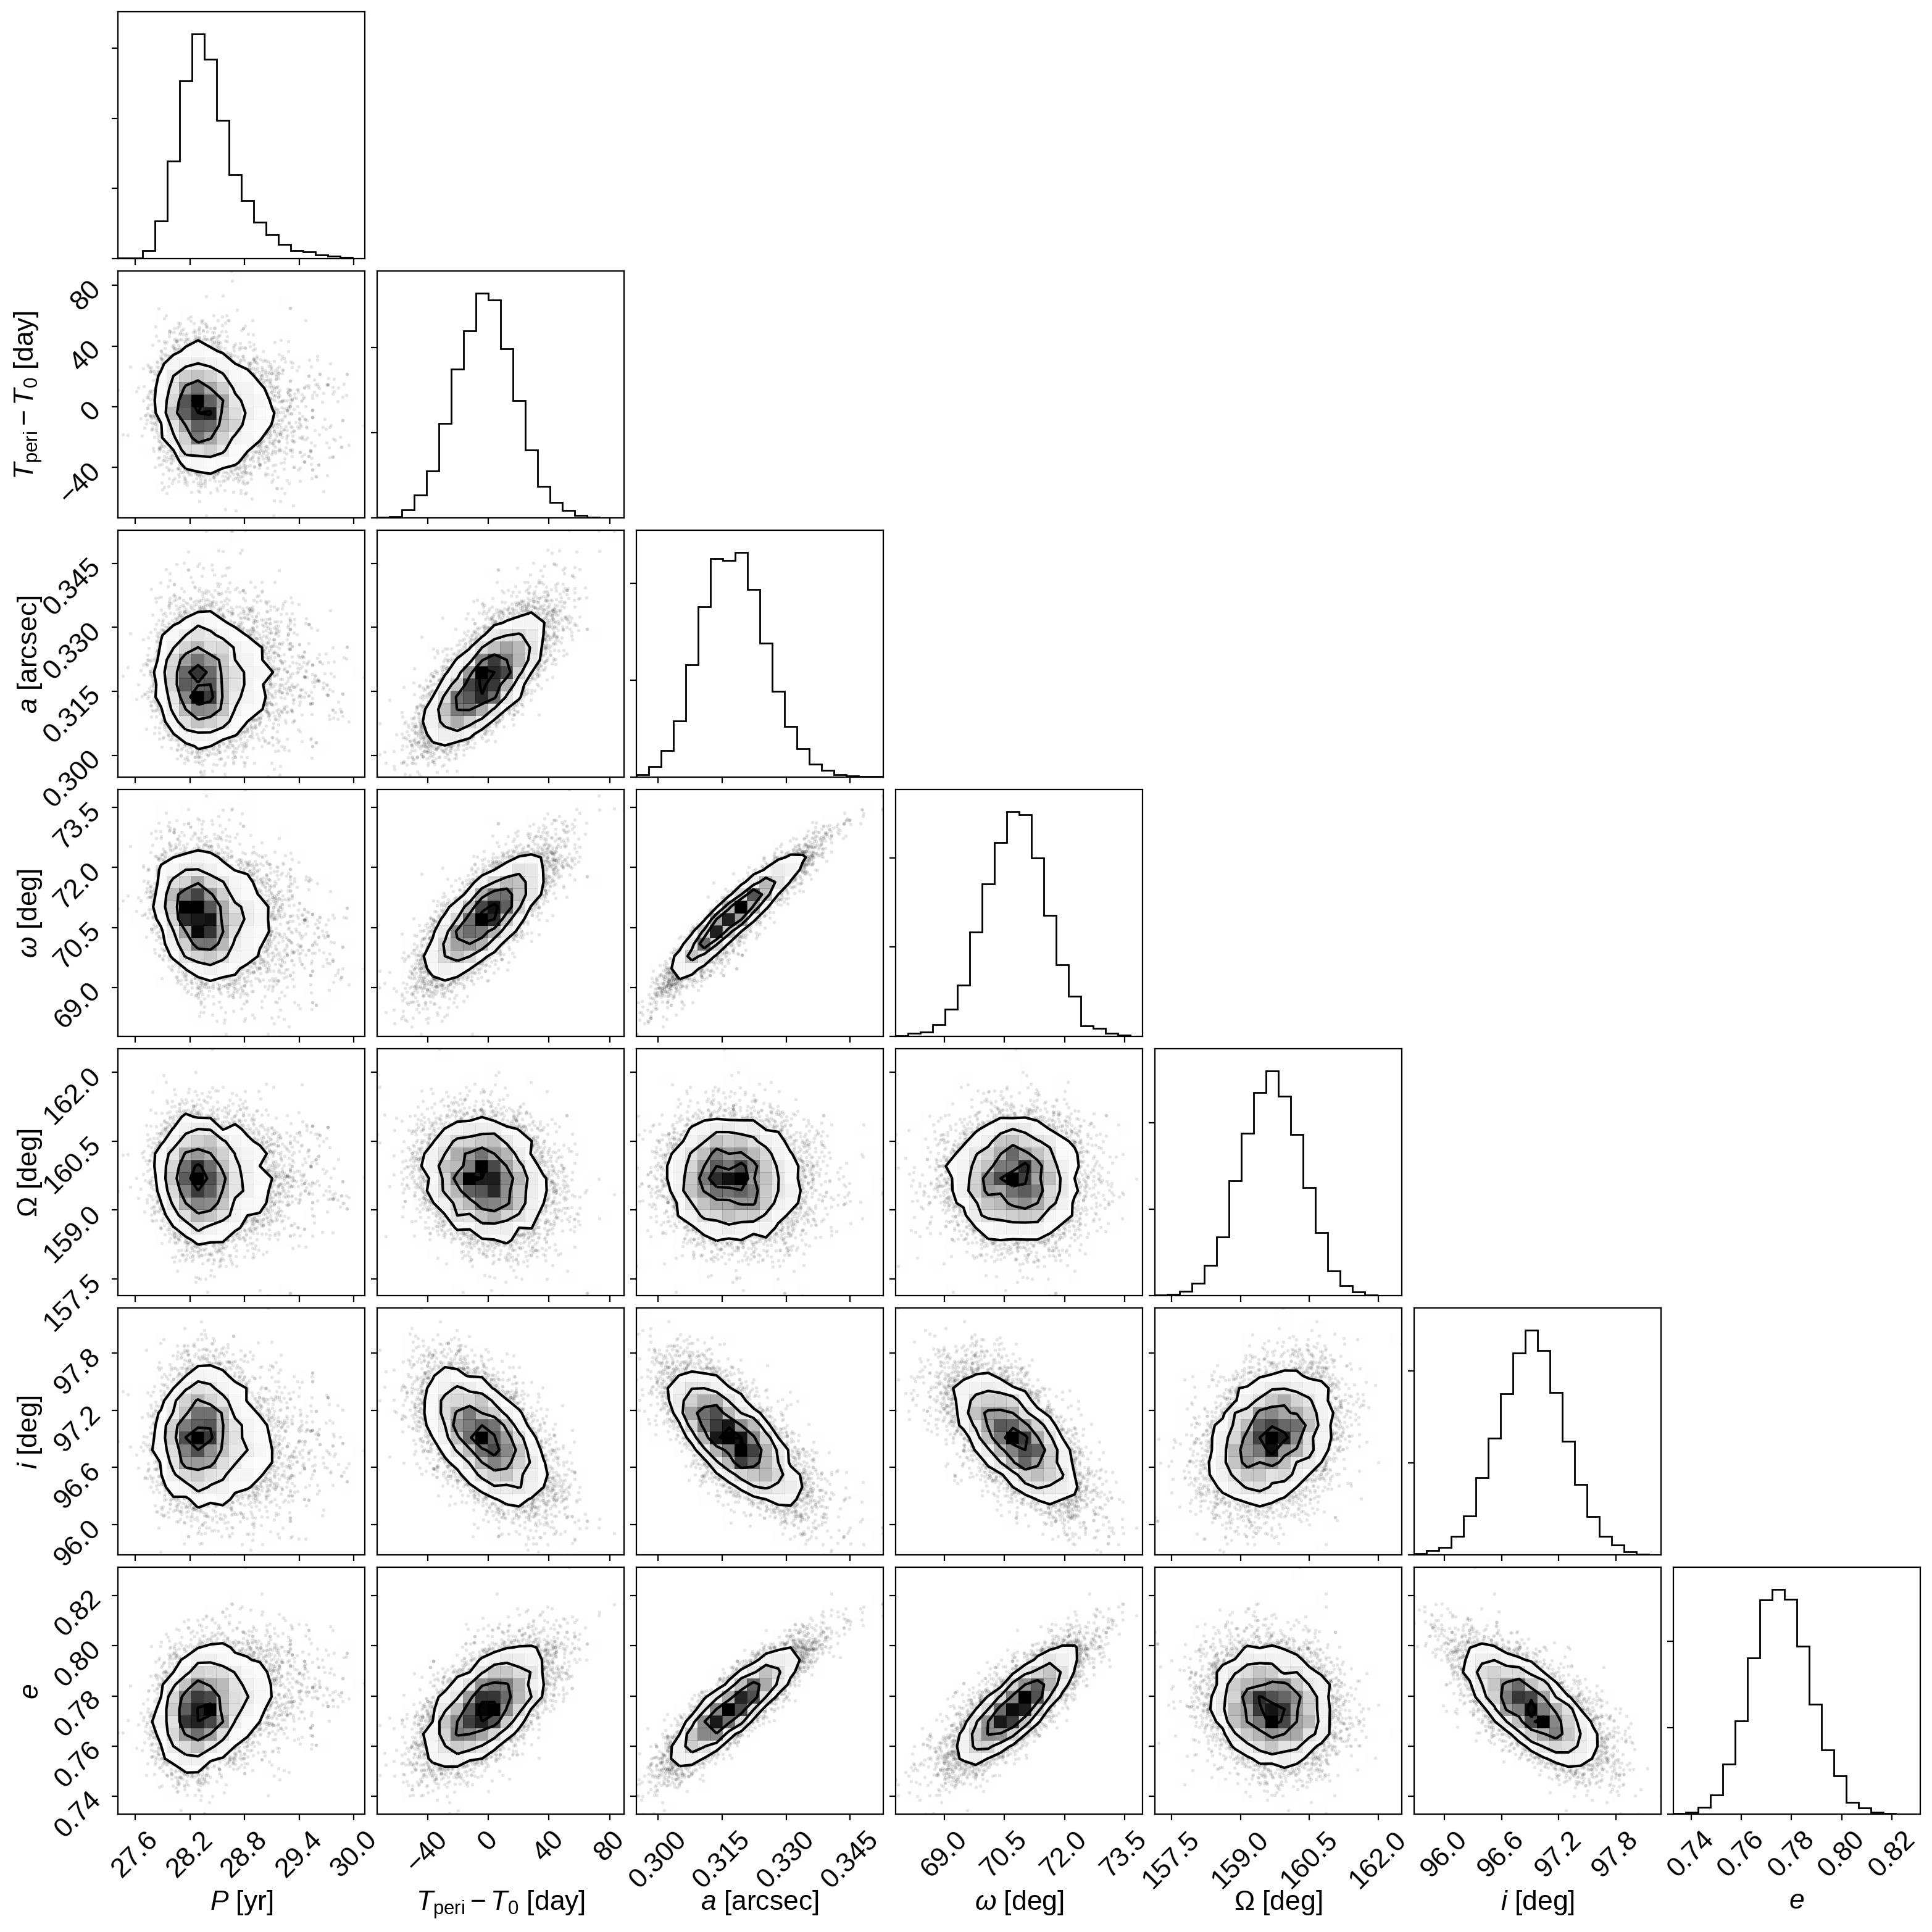

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

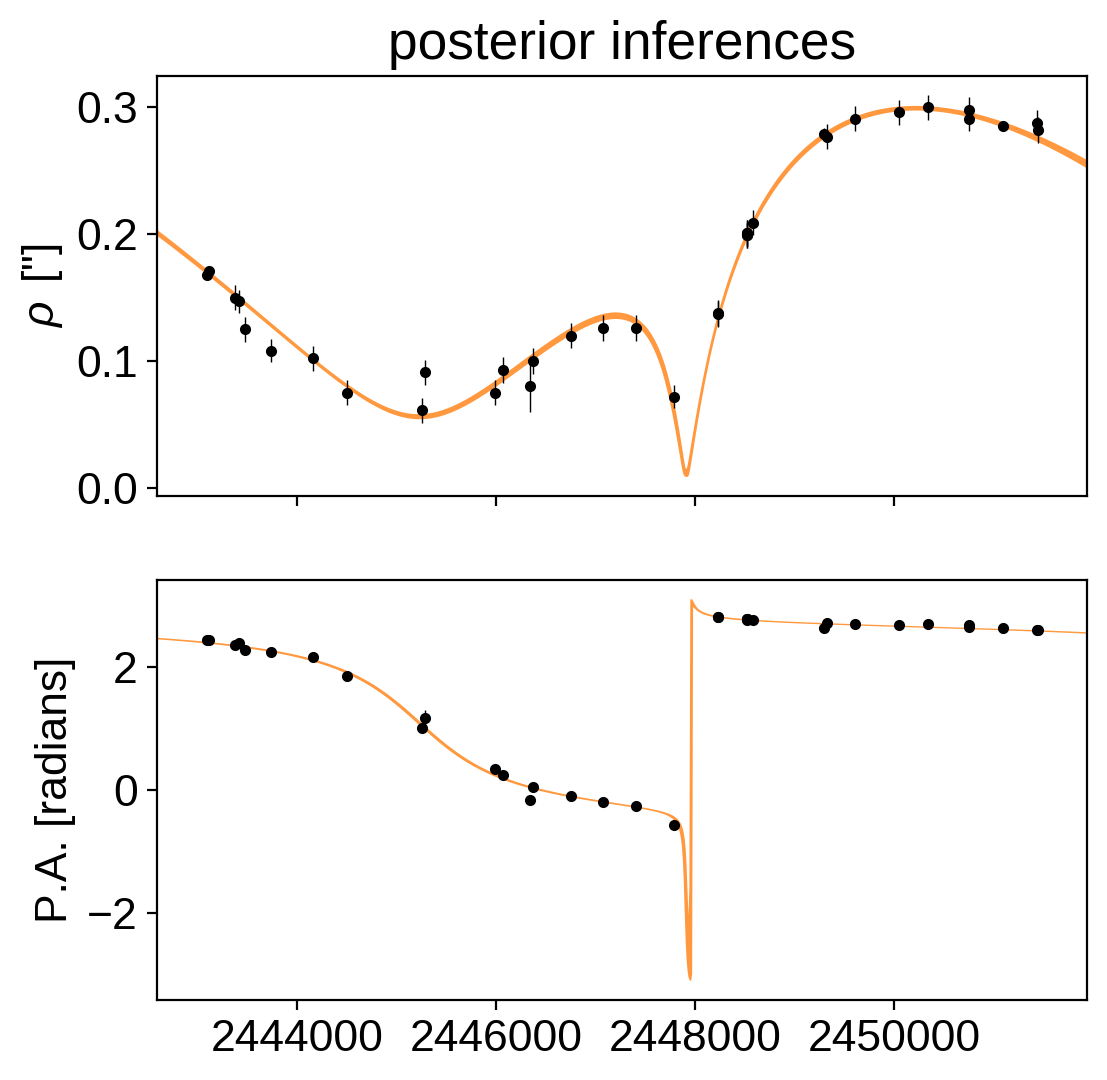

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 448.06it/s, logp=1.076402e+02]

2it [00:00, 581.77it/s, logp=1.476711e+02]

3it [00:00, 614.07it/s, logp=1.084303e+02]

4it [00:00, 703.39it/s, logp=1.485840e+02]

5it [00:00, 738.67it/s, logp=1.497845e+02]

6it [00:00, 758.85it/s, logp=1.499280e+02]

7it [00:00, 785.47it/s, logp=1.499286e+02]

8it [00:00, 811.85it/s, logp=1.499286e+02]

9it [00:00, 826.88it/s, logp=1.499286e+02]

10it [00:02,  4.90it/s, logp=1.499286e+02]


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 721.54it/s, logp=1.499286e+02]

2it [00:00, 663.45it/s, logp=-1.185553e+04]

3it [00:00, 748.54it/s, logp=1.499517e+02] 

4it [00:00, 784.75it/s, logp=1.499982e+02]

5it [00:00, 788.88it/s, logp=1.501832e+02]

6it [00:00, 823.11it/s, logp=1.509035e+02]

7it [00:00, 854.01it/s, logp=1.535077e+02]

8it [00:00, 849.14it/s, logp=1.593811e+02]

9it [00:00, 834.06it/s, logp=1.662757e+02]

10it [00:00, 844.52it/s, logp=1.694242e+02]

11it [00:00, 835.02it/s, logp=1.703302e+02]

12it [00:00, 844.58it/s, logp=1.704061e+02]

13it [00:00, 843.89it/s, logp=1.704094e+02]

14it [00:00, 831.30it/s, logp=1.704128e+02]

15it [00:00, 830.83it/s, logp=1.704184e+02]

16it [00:00, 820.74it/s, logp=1.704249e+02]

17it [00:00, 823.47it/s, logp=1.704265e+02]

18it [00:00, 831.64it/s, logp=1.704268e+02]

19it [00:00, 816.68it/s, logp=1.704268e+02]

20it [00:00, 815.75it/s, logp=1.704268e+02]

21it [00:00, 812.59it/s, logp=1.704268e+02]

22it [00:00, 26.79it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 363.87it/s, logp=1.704268e+02]

2it [00:00, 451.78it/s, logp=-4.518236e+03]

3it [00:00, 550.07it/s, logp=1.710200e+02] 

4it [00:00, 588.80it/s, logp=1.695336e+02]

5it [00:00, 616.43it/s, logp=1.711520e+02]

6it [00:00, 614.16it/s, logp=1.714066e+02]

7it [00:00, 646.49it/s, logp=1.721879e+02]

8it [00:00, 654.91it/s, logp=1.742150e+02]

9it [00:00, 670.49it/s, logp=1.812157e+02]

10it [00:00, 680.60it/s, logp=1.949820e+02]

11it [00:00, 688.14it/s, logp=1.964691e+02]

12it [00:00, 686.80it/s, logp=1.992100e+02]

13it [00:00, 687.63it/s, logp=2.038785e+02]

14it [00:00, 691.49it/s, logp=2.102587e+02]

15it [00:00, 698.75it/s, logp=2.122110e+02]

16it [00:00, 706.34it/s, logp=2.126408e+02]

17it [00:00, 710.67it/s, logp=2.126846e+02]

18it [00:00, 698.24it/s, logp=2.126998e+02]

19it [00:00, 707.06it/s, logp=2.127263e+02]

20it [00:00, 713.85it/s, logp=2.127699e+02]

21it [00:00, 684.57it/s, logp=2.128244e+02]

22it [00:00, 691.53it/s, logp=2.128398e+02]

23it [00:00, 685.84it/s, logp=2.128456e+02]

24it [00:00, 686.79it/s, logp=2.128460e+02]

25it [00:00, 688.71it/s, logp=2.128463e+02]

26it [00:00, 694.29it/s, logp=2.128468e+02]

27it [00:00, 700.80it/s, logp=2.128475e+02]

28it [00:00, 706.83it/s, logp=2.128479e+02]

29it [00:00, 709.97it/s, logp=2.128480e+02]

30it [00:00, 712.76it/s, logp=2.128480e+02]

31it [00:00, 717.33it/s, logp=2.128480e+02]

32it [00:00, 719.33it/s, logp=2.128480e+02]

33it [00:00, 721.02it/s, logp=2.128480e+02]

34it [00:00, 40.26it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 461.12it/s, logp=2.128480e+02]

2it [00:00, 510.69it/s, logp=-4.375386e+03]

3it [00:00, 614.46it/s, logp=2.129960e+02] 

4it [00:00, 620.51it/s, logp=2.131453e+02]

5it [00:00, 649.74it/s, logp=2.132729e+02]

6it [00:00, 677.27it/s, logp=2.132857e+02]

7it [00:00, 666.37it/s, logp=2.132857e+02]

8it [00:00, 687.39it/s, logp=2.132860e+02]

9it [00:00, 675.50it/s, logp=2.132860e+02]

10it [00:00, 679.81it/s, logp=2.132860e+02]

11it [00:00, 12.80it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410485


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 404.35it/s, logp=2.132860e+02]

2it [00:00, 483.05it/s, logp=-4.038433e+03]

3it [00:00, 570.42it/s, logp=2.152474e+02] 

4it [00:00, 598.46it/s, logp=1.676432e+02]

5it [00:00, 640.78it/s, logp=2.153207e+02]

6it [00:00, 636.24it/s, logp=2.154316e+02]

7it [00:00, 653.87it/s, logp=2.156115e+02]

8it [00:00, 660.34it/s, logp=2.158705e+02]

9it [00:00, 665.07it/s, logp=2.160160e+02]

10it [00:00, 667.55it/s, logp=2.158620e+02]

11it [00:00, 687.02it/s, logp=2.160652e+02]

12it [00:00, 694.87it/s, logp=2.160890e+02]

13it [00:00, 677.14it/s, logp=2.161353e+02]

14it [00:00, 692.42it/s, logp=2.162848e+02]

15it [00:00, 670.13it/s, logp=2.166196e+02]

16it [00:00, 668.42it/s, logp=2.171740e+02]

17it [00:00, 668.62it/s, logp=2.175761e+02]

18it [00:00, 665.02it/s, logp=2.174845e+02]

19it [00:00, 675.61it/s, logp=2.176565e+02]

20it [00:00, 679.80it/s, logp=2.177043e+02]

21it [00:00, 674.62it/s, logp=2.177335e+02]

22it [00:00, 680.91it/s, logp=2.177622e+02]

23it [00:00, 677.27it/s, logp=2.177547e+02]

24it [00:00, 684.93it/s, logp=2.177767e+02]

25it [00:00, 689.73it/s, logp=2.177873e+02]

26it [00:00, 693.60it/s, logp=2.177936e+02]

27it [00:00, 686.25it/s, logp=2.178014e+02]

28it [00:00, 685.70it/s, logp=2.178034e+02]

29it [00:00, 687.47it/s, logp=2.178054e+02]

30it [00:00, 688.25it/s, logp=2.178058e+02]

31it [00:00, 687.26it/s, logp=2.178059e+02]

32it [00:00, 690.56it/s, logp=2.178059e+02]

33it [00:00, 694.38it/s, logp=2.178059e+02]

34it [00:00, 691.74it/s, logp=2.178059e+02]

35it [00:00, 692.10it/s, logp=2.178059e+02]

36it [00:00, 694.04it/s, logp=2.178059e+02]

37it [00:00, 683.05it/s, logp=2.178059e+02]

38it [00:00, 677.09it/s, logp=2.178059e+02]

39it [00:00, 680.22it/s, logp=2.178059e+02]

40it [00:00, 683.87it/s, logp=2.178059e+02]

41it [00:00, 686.87it/s, logp=2.178059e+02]

42it [00:00, 689.08it/s, logp=2.178059e+02]

43it [00:00, 687.53it/s, logp=2.178059e+02]

44it [00:00, 683.63it/s, logp=2.178059e+02]

45it [00:00, 684.76it/s, logp=2.178059e+02]

46it [00:00, 685.65it/s, logp=2.178059e+02]

47it [00:00, 684.58it/s, logp=2.178059e+02]

48it [00:00, 687.01it/s, logp=2.178059e+02]

49it [00:00, 682.66it/s, logp=2.178059e+02]

50it [00:00, 685.11it/s, logp=2.178059e+02]

51it [00:00, 688.62it/s, logp=2.178059e+02]

52it [00:00, 690.84it/s, logp=2.178059e+02]

53it [00:00, 692.31it/s, logp=2.178059e+02]

54it [00:00, 694.63it/s, logp=2.178059e+02]

55it [00:00, 697.34it/s, logp=2.178059e+02]

56it [00:00, 697.67it/s, logp=2.178059e+02]

57it [00:00, 693.69it/s, logp=2.178059e+02]

58it [00:00, 694.91it/s, logp=2.178059e+02]

59it [00:00, 694.68it/s, logp=2.178059e+02]

60it [00:00, 677.73it/s, logp=2.178059e+02]

61it [00:00, 674.89it/s, logp=2.178059e+02]

62it [00:00, 676.53it/s, logp=2.178059e+02]

63it [00:00, 676.99it/s, logp=2.178059e+02]

64it [00:00, 678.48it/s, logp=2.178059e+02]

65it [00:00, 679.59it/s, logp=2.178059e+02]

66it [00:00, 679.40it/s, logp=2.178059e+02]

67it [00:00, 681.83it/s, logp=2.178059e+02]

68it [00:00, 682.70it/s, logp=2.178059e+02]

69it [00:00, 689.67it/s, logp=2.178059e+02]

69it [00:00, 689.67it/s, logp=2.178059e+02]

70it [00:00, 689.67it/s, logp=2.178059e+02]

71it [00:00, 689.67it/s, logp=2.178059e+02]

72it [00:00, 689.67it/s, logp=2.178059e+02]

73it [00:00, 689.67it/s, logp=2.178059e+02]

74it [00:00, 689.67it/s, logp=2.178059e+02]

75it [00:00, 689.67it/s, logp=2.178059e+02]

76it [00:00, 689.67it/s, logp=2.178059e+02]

77it [00:00, 689.67it/s, logp=2.178059e+02]

78it [00:00, 689.67it/s, logp=2.178059e+02]

79it [00:00, 689.67it/s, logp=2.178059e+02]

80it [00:00, 689.67it/s, logp=2.178059e+02]

81it [00:00, 689.67it/s, logp=2.178059e+02]

82it [00:00, 689.67it/s, logp=2.178059e+02]

83it [00:00, 689.67it/s, logp=2.178059e+02]

84it [00:00, 689.67it/s, logp=2.178059e+02]

85it [00:00, 689.67it/s, logp=2.178059e+02]

86it [00:00, 689.67it/s, logp=2.178059e+02]

87it [00:00, 689.67it/s, logp=2.178059e+02]

88it [00:00, 689.67it/s, logp=2.178059e+02]

89it [00:00, 689.67it/s, logp=2.178059e+02]

90it [00:00, 689.67it/s, logp=2.178059e+02]

91it [00:00, 689.67it/s, logp=2.178059e+02]

92it [00:00, 689.67it/s, logp=2.178059e+02]

93it [00:00, 689.67it/s, logp=2.178059e+02]

94it [00:00, 689.67it/s, logp=2.178059e+02]

95it [00:00, 689.67it/s, logp=2.178059e+02]

96it [00:00, 689.67it/s, logp=2.178059e+02]

97it [00:00, 689.67it/s, logp=2.178059e+02]

98it [00:00, 689.67it/s, logp=2.178059e+02]

99it [00:00, 689.67it/s, logp=2.178059e+02]

100it [00:00, 689.67it/s, logp=2.178059e+02]

101it [00:00, 689.67it/s, logp=2.178059e+02]

102it [00:00, 689.67it/s, logp=2.178059e+02]

103it [00:00, 689.67it/s, logp=2.178059e+02]

104it [00:00, 689.67it/s, logp=2.178059e+02]

105it [00:00, 689.67it/s, logp=2.178059e+02]

106it [00:00, 689.67it/s, logp=2.178059e+02]

107it [00:00, 689.67it/s, logp=2.178059e+02]

108it [00:00, 689.67it/s, logp=2.178059e+02]

109it [00:00, 689.67it/s, logp=2.178059e+02]

110it [00:00, 689.67it/s, logp=2.178059e+02]

111it [00:00, 689.67it/s, logp=2.178059e+02]

112it [00:00, 689.67it/s, logp=2.178059e+02]

113it [00:00, 689.67it/s, logp=2.178059e+02]

114it [00:00, 689.67it/s, logp=2.178059e+02]

115it [00:00, 689.67it/s, logp=2.178059e+02]

116it [00:00, 689.67it/s, logp=2.178059e+02]

117it [00:00, 689.67it/s, logp=2.178059e+02]

118it [00:00, 689.67it/s, logp=2.178059e+02]

119it [00:00, 689.67it/s, logp=2.178059e+02]

120it [00:00, 689.67it/s, logp=2.178059e+02]

121it [00:00, 689.67it/s, logp=2.178059e+02]

122it [00:00, 689.67it/s, logp=2.178059e+02]

123it [00:00, 689.67it/s, logp=2.178059e+02]

124it [00:00, 689.67it/s, logp=2.178059e+02]

125it [00:00, 689.67it/s, logp=2.178059e+02]

126it [00:00, 689.67it/s, logp=2.178059e+02]

127it [00:00, 689.67it/s, logp=2.178059e+02]

128it [00:00, 689.67it/s, logp=2.178059e+02]

129it [00:00, 689.67it/s, logp=2.178059e+02]

130it [00:00, 689.67it/s, logp=2.178059e+02]

131it [00:00, 689.67it/s, logp=2.178059e+02]

132it [00:00, 689.67it/s, logp=2.178059e+02]

133it [00:00, 689.67it/s, logp=2.178059e+02]

134it [00:00, 689.67it/s, logp=2.178059e+02]

135it [00:00, 689.67it/s, logp=2.178059e+02]

136it [00:00, 689.67it/s, logp=2.178059e+02]

137it [00:00, 689.67it/s, logp=2.178059e+02]

138it [00:00, 689.67it/s, logp=2.178059e+02]

139it [00:00, 690.88it/s, logp=2.178059e+02]

139it [00:00, 690.88it/s, logp=2.178059e+02]

140it [00:00, 690.88it/s, logp=2.178059e+02]

141it [00:00, 690.88it/s, logp=2.178059e+02]

142it [00:00, 690.88it/s, logp=2.178059e+02]

143it [00:00, 690.88it/s, logp=2.178059e+02]

144it [00:00, 690.88it/s, logp=2.178059e+02]

145it [00:00, 690.88it/s, logp=2.178059e+02]

146it [00:00, 690.88it/s, logp=2.178059e+02]

147it [00:00, 690.88it/s, logp=2.178059e+02]

148it [00:00, 690.88it/s, logp=2.178059e+02]

149it [00:00, 690.88it/s, logp=2.178059e+02]

150it [00:00, 690.88it/s, logp=2.178059e+02]

151it [00:00, 690.88it/s, logp=2.178059e+02]

152it [00:00, 690.88it/s, logp=2.178059e+02]

153it [00:00, 690.88it/s, logp=2.178059e+02]

154it [00:00, 690.88it/s, logp=2.178059e+02]

155it [00:00, 690.88it/s, logp=2.178059e+02]

156it [00:00, 690.88it/s, logp=2.178059e+02]

157it [00:00, 690.88it/s, logp=2.178059e+02]

158it [00:00, 690.88it/s, logp=2.178059e+02]

159it [00:00, 690.88it/s, logp=2.178059e+02]

160it [00:00, 690.88it/s, logp=2.178059e+02]

161it [00:00, 690.88it/s, logp=2.178059e+02]

162it [00:00, 690.88it/s, logp=2.178059e+02]

163it [00:00, 690.88it/s, logp=2.178059e+02]

164it [00:00, 690.88it/s, logp=2.178059e+02]

165it [00:00, 690.88it/s, logp=2.178059e+02]

166it [00:00, 690.88it/s, logp=2.178059e+02]

167it [00:00, 690.88it/s, logp=2.178059e+02]

168it [00:00, 690.88it/s, logp=2.178059e+02]

169it [00:00, 690.88it/s, logp=2.178059e+02]

170it [00:00, 690.88it/s, logp=2.178059e+02]

171it [00:00, 690.88it/s, logp=2.178059e+02]

172it [00:00, 690.88it/s, logp=2.178059e+02]

173it [00:00, 690.88it/s, logp=2.178059e+02]

174it [00:00, 690.88it/s, logp=2.178059e+02]

175it [00:00, 690.88it/s, logp=2.178059e+02]

176it [00:00, 690.88it/s, logp=2.178059e+02]

177it [00:00, 690.88it/s, logp=2.178059e+02]

178it [00:00, 690.88it/s, logp=2.178059e+02]

179it [00:00, 690.88it/s, logp=2.178059e+02]

180it [00:00, 690.88it/s, logp=2.178059e+02]

181it [00:00, 690.88it/s, logp=2.178059e+02]

182it [00:00, 690.88it/s, logp=2.178059e+02]

183it [00:00, 690.88it/s, logp=2.178059e+02]

184it [00:00, 690.88it/s, logp=2.178059e+02]

185it [00:00, 690.88it/s, logp=2.178059e+02]

186it [00:00, 690.88it/s, logp=2.178059e+02]

187it [00:00, 690.88it/s, logp=2.178059e+02]

188it [00:00, 690.88it/s, logp=2.178059e+02]

189it [00:00, 690.88it/s, logp=2.178059e+02]

190it [00:00, 690.88it/s, logp=2.178059e+02]

191it [00:00, 690.88it/s, logp=2.178059e+02]

192it [00:00, 690.88it/s, logp=2.178059e+02]

193it [00:00, 690.88it/s, logp=2.178059e+02]

194it [00:00, 690.88it/s, logp=2.178059e+02]

195it [00:00, 690.88it/s, logp=2.178059e+02]

196it [00:00, 690.88it/s, logp=2.178059e+02]

197it [00:00, 690.88it/s, logp=2.178059e+02]

198it [00:00, 690.88it/s, logp=2.178059e+02]

199it [00:00, 690.88it/s, logp=2.178059e+02]

200it [00:00, 690.88it/s, logp=2.178059e+02]

201it [00:00, 690.88it/s, logp=2.178059e+02]

202it [00:00, 690.88it/s, logp=2.178059e+02]

203it [00:00, 690.88it/s, logp=2.178059e+02]

204it [00:00, 690.88it/s, logp=2.178059e+02]

205it [00:00, 690.88it/s, logp=2.178059e+02]

206it [00:00, 690.88it/s, logp=2.178059e+02]

207it [00:00, 690.88it/s, logp=2.178059e+02]

208it [00:00, 690.88it/s, logp=2.178059e+02]

209it [00:00, 692.34it/s, logp=2.178059e+02]

209it [00:00, 692.34it/s, logp=2.178059e+02]

210it [00:00, 692.34it/s, logp=2.178059e+02]

211it [00:00, 692.34it/s, logp=2.178059e+02]

212it [00:00, 692.34it/s, logp=2.178059e+02]

213it [00:00, 692.34it/s, logp=2.178059e+02]

214it [00:00, 692.34it/s, logp=2.178059e+02]

215it [00:00, 692.34it/s, logp=2.178059e+02]

216it [00:00, 692.34it/s, logp=2.178059e+02]

217it [00:00, 692.34it/s, logp=2.178059e+02]

218it [00:00, 692.34it/s, logp=2.178059e+02]

219it [00:00, 692.34it/s, logp=2.178059e+02]

220it [00:00, 692.34it/s, logp=2.178059e+02]

221it [00:00, 692.34it/s, logp=2.178059e+02]

222it [00:00, 692.34it/s, logp=2.178059e+02]

223it [00:00, 692.34it/s, logp=2.178059e+02]

224it [00:00, 692.34it/s, logp=2.178059e+02]

225it [00:00, 692.34it/s, logp=2.178059e+02]

226it [00:00, 692.34it/s, logp=2.178059e+02]

227it [00:00, 692.34it/s, logp=2.178059e+02]

228it [00:00, 692.34it/s, logp=2.178059e+02]

229it [00:00, 692.34it/s, logp=2.178059e+02]

230it [00:00, 692.34it/s, logp=2.178059e+02]

231it [00:00, 692.34it/s, logp=2.178059e+02]

232it [00:00, 692.34it/s, logp=2.178059e+02]

233it [00:00, 692.34it/s, logp=2.178059e+02]

234it [00:00, 692.34it/s, logp=2.178059e+02]

235it [00:00, 692.34it/s, logp=2.178059e+02]

236it [00:00, 692.34it/s, logp=2.178059e+02]

237it [00:00, 692.34it/s, logp=2.178059e+02]

238it [00:00, 692.34it/s, logp=2.178059e+02]

239it [00:00, 692.34it/s, logp=2.178059e+02]

240it [00:00, 692.34it/s, logp=2.178059e+02]

241it [00:00, 692.34it/s, logp=2.178059e+02]

242it [00:00, 692.34it/s, logp=2.178059e+02]

243it [00:00, 692.34it/s, logp=2.178059e+02]

244it [00:01, 143.68it/s, logp=2.178059e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410485 -> 217.80586833503276


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<06:38, 45.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/18000 [00:00<10:46, 27.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/18000 [00:00<14:01, 21.37draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<16:41, 17.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<17:48, 16.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<18:32, 16.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<18:59, 15.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/18000 [00:01<19:19, 15.51draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/18000 [00:01<19:30, 15.36draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/18000 [00:01<19:32, 15.33draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/18000 [00:01<19:45, 15.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/18000 [00:01<19:34, 15.30draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<19:15, 15.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/18000 [00:01<20:09, 14.85draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/18000 [00:02<20:17, 14.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/18000 [00:02<20:24, 14.66draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/18000 [00:02<17:15, 17.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/18000 [00:02<18:21, 16.30draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/18000 [00:02<18:54, 15.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 48/18000 [00:02<19:22, 15.45draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/18000 [00:02<15:54, 18.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/18000 [00:03<15:11, 19.68draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/18000 [00:03<14:52, 20.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/18000 [00:03<15:02, 19.88draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/18000 [00:03<17:10, 17.40draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 66/18000 [00:03<17:59, 16.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 68/18000 [00:03<19:05, 15.66draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 70/18000 [00:03<19:44, 15.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 73/18000 [00:04<17:48, 16.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/18000 [00:04<19:06, 15.63draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 77/18000 [00:04<19:33, 15.27draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:04<19:49, 15.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 81/18000 [00:04<19:53, 15.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 83/18000 [00:04<19:01, 15.70draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 87/18000 [00:04<17:07, 17.44draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 90/18000 [00:05<15:53, 18.77draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 93/18000 [00:05<15:04, 19.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/18000 [00:05<17:05, 17.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 99/18000 [00:05<15:19, 19.46draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/18000 [00:05<15:49, 18.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/18000 [00:05<17:08, 17.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/18000 [00:06<18:00, 16.56draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 109/18000 [00:06<16:33, 18.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/18000 [00:06<18:26, 16.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 113/18000 [00:06<18:52, 15.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 115/18000 [00:06<19:15, 15.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 117/18000 [00:06<19:56, 14.95draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/18000 [00:06<20:04, 14.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/18000 [00:06<20:11, 14.76draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/18000 [00:07<19:00, 15.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/18000 [00:07<18:24, 16.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/18000 [00:07<19:17, 15.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/18000 [00:07<19:48, 15.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 132/18000 [00:07<20:15, 14.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/18000 [00:07<20:28, 14.54draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 136/18000 [00:07<20:34, 14.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/18000 [00:08<21:08, 14.08draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/18000 [00:08<19:37, 15.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/18000 [00:08<18:53, 15.75draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 148/18000 [00:08<16:14, 18.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/18000 [00:08<16:10, 18.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 153/18000 [00:08<17:34, 16.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 155/18000 [00:09<18:38, 15.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 157/18000 [00:09<19:35, 15.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 159/18000 [00:09<20:45, 14.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 161/18000 [00:09<20:52, 14.25draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/18000 [00:09<20:42, 14.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 166/18000 [00:09<19:47, 15.02draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 168/18000 [00:09<19:43, 15.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/18000 [00:10<17:38, 16.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 173/18000 [00:10<18:23, 16.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/18000 [00:10<18:51, 15.75draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 177/18000 [00:10<19:14, 15.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/18000 [00:10<19:53, 14.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 181/18000 [00:10<20:12, 14.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 183/18000 [00:10<20:11, 14.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 186/18000 [00:11<18:35, 15.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 188/18000 [00:11<19:06, 15.53draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 190/18000 [00:11<19:15, 15.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 192/18000 [00:11<19:32, 15.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 195/18000 [00:11<17:28, 16.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 197/18000 [00:11<18:04, 16.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/18000 [00:11<18:30, 16.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 202/18000 [00:11<16:58, 17.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 204/18000 [00:12<16:29, 17.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 206/18000 [00:12<17:43, 16.73draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 208/18000 [00:12<18:39, 15.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 211/18000 [00:12<17:47, 16.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 214/18000 [00:12<16:22, 18.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 217/18000 [00:12<14:36, 20.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 223/18000 [00:12<11:50, 25.01draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 233/18000 [00:12<09:13, 32.08draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 245/18000 [00:13<07:12, 41.05draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 261/18000 [00:13<05:38, 52.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 272/18000 [00:13<04:46, 61.90draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 284/18000 [00:13<04:05, 72.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/18000 [00:13<03:34, 82.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 312/18000 [00:13<03:08, 94.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 331/18000 [00:13<02:41, 109.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 347/18000 [00:13<02:25, 120.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 363/18000 [00:13<02:17, 128.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 383/18000 [00:13<02:03, 143.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 401/18000 [00:14<01:56, 150.89draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 418/18000 [00:14<01:54, 154.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 437/18000 [00:14<01:47, 162.94draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 456/18000 [00:14<01:44, 167.79draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 475/18000 [00:14<01:42, 171.78draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 494/18000 [00:14<01:41, 173.15draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 512/18000 [00:14<01:46, 164.84draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 529/18000 [00:14<01:45, 166.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 548/18000 [00:14<01:41, 171.22draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 571/18000 [00:15<01:34, 183.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 593/18000 [00:15<01:30, 192.74draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 613/18000 [00:15<01:33, 186.75draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 632/18000 [00:15<01:35, 181.60draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 651/18000 [00:15<01:34, 182.97draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 672/18000 [00:15<01:32, 186.42draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 691/18000 [00:15<01:37, 177.77draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 709/18000 [00:15<01:45, 163.15draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 726/18000 [00:15<01:48, 159.15draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 743/18000 [00:16<01:51, 154.34draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 759/18000 [00:16<01:54, 150.00draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 775/18000 [00:16<02:04, 137.97draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 792/18000 [00:16<01:58, 145.19draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 807/18000 [00:16<01:57, 146.42draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 825/18000 [00:16<01:50, 154.98draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 845/18000 [00:16<01:44, 163.55draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 864/18000 [00:16<01:41, 169.15draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 885/18000 [00:16<01:36, 178.21draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 904/18000 [00:17<01:34, 180.31draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 923/18000 [00:17<01:40, 169.13draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 941/18000 [00:17<01:43, 164.23draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 959/18000 [00:17<01:43, 165.19draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 976/18000 [00:17<01:42, 166.54draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 993/18000 [00:17<01:45, 161.59draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1010/18000 [00:17<01:49, 154.90draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1026/18000 [00:17<01:50, 153.15draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1043/18000 [00:17<01:49, 155.13draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1061/18000 [00:18<01:46, 159.30draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1081/18000 [00:18<01:41, 167.42draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1098/18000 [00:18<01:47, 156.70draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1118/18000 [00:18<01:42, 165.47draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1136/18000 [00:18<01:41, 166.28draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1153/18000 [00:18<01:43, 162.13draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1175/18000 [00:18<01:36, 174.06draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1193/18000 [00:18<01:39, 168.98draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1211/18000 [00:18<01:42, 163.05draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1228/18000 [00:19<01:43, 161.91draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1245/18000 [00:19<01:42, 163.59draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1262/18000 [00:19<01:50, 151.11draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1278/18000 [00:19<02:15, 123.65draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1292/18000 [00:19<02:19, 119.82draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1308/18000 [00:19<02:08, 129.50draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1324/18000 [00:19<02:02, 135.82draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1341/18000 [00:19<01:55, 144.10draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1357/18000 [00:19<01:52, 148.26draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1374/18000 [00:20<01:50, 150.97draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1390/18000 [00:20<01:59, 138.62draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1405/18000 [00:20<02:11, 126.42draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1421/18000 [00:20<02:05, 132.23draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1440/18000 [00:20<01:56, 142.76draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1455/18000 [00:20<01:58, 139.32draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1470/18000 [00:20<02:02, 135.26draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1484/18000 [00:20<02:03, 134.18draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1498/18000 [00:21<02:10, 126.80draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1511/18000 [00:21<02:11, 125.62draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1528/18000 [00:21<02:02, 134.60draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1544/18000 [00:21<01:58, 139.45draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1561/18000 [00:21<01:52, 145.59draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1577/18000 [00:21<01:51, 147.42draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1594/18000 [00:21<01:47, 152.29draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1612/18000 [00:21<01:42, 159.43draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1629/18000 [00:21<01:43, 158.29draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1645/18000 [00:21<01:43, 157.27draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1661/18000 [00:22<01:51, 145.93draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1678/18000 [00:22<01:48, 149.81draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1694/18000 [00:22<01:57, 138.92draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1709/18000 [00:22<01:59, 135.99draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1725/18000 [00:22<01:54, 141.56draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1740/18000 [00:22<01:57, 138.36draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1755/18000 [00:22<01:55, 140.58draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1772/18000 [00:22<01:50, 147.46draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1787/18000 [00:23<01:53, 143.42draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1802/18000 [00:23<01:56, 138.90draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1819/18000 [00:23<01:50, 145.87draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1835/18000 [00:23<01:48, 148.99draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1851/18000 [00:23<01:49, 147.29draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1870/18000 [00:23<01:43, 155.50draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1889/18000 [00:23<01:39, 162.25draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1906/18000 [00:23<01:38, 163.65draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1924/18000 [00:23<01:36, 167.18draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1944/18000 [00:23<01:32, 174.52draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1962/18000 [00:24<01:37, 165.07draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1979/18000 [00:24<01:44, 153.73draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1999/18000 [00:24<01:37, 164.45draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2018/18000 [00:24<01:34, 169.54draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2037/18000 [00:24<01:31, 174.66draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2055/18000 [00:24<01:44, 152.94draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2071/18000 [00:24<01:50, 144.48draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2087/18000 [00:24<01:50, 143.84draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2102/18000 [00:25<01:54, 139.28draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2117/18000 [00:25<02:05, 126.77draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2131/18000 [00:25<02:15, 117.12draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2144/18000 [00:25<02:11, 120.19draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2160/18000 [00:25<02:03, 128.43draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2176/18000 [00:25<01:57, 135.17draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2191/18000 [00:25<01:57, 134.30draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2205/18000 [00:25<02:01, 129.91draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2219/18000 [00:25<02:02, 129.12draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2233/18000 [00:26<02:01, 130.27draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2248/18000 [00:26<01:57, 133.90draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2262/18000 [00:26<02:02, 128.64draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2275/18000 [00:26<02:05, 125.16draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2292/18000 [00:26<01:59, 131.51draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2307/18000 [00:26<01:58, 132.34draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2321/18000 [00:26<01:59, 130.99draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2338/18000 [00:26<01:52, 138.65draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2356/18000 [00:26<01:45, 148.52draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2372/18000 [00:27<01:44, 148.84draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2388/18000 [00:27<01:47, 144.74draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2403/18000 [00:27<01:49, 142.17draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2421/18000 [00:27<01:45, 147.93draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2436/18000 [00:27<01:48, 143.35draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2451/18000 [00:27<01:48, 143.71draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2466/18000 [00:27<01:51, 139.70draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2481/18000 [00:27<01:54, 135.15draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2497/18000 [00:27<01:49, 140.97draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2513/18000 [00:28<01:46, 145.93draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2528/18000 [00:28<01:48, 142.04draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2543/18000 [00:28<01:50, 139.66draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2560/18000 [00:28<01:45, 146.62draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2576/18000 [00:28<01:42, 149.91draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2593/18000 [00:28<01:40, 153.89draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2612/18000 [00:28<01:34, 162.93draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2629/18000 [00:28<01:35, 160.77draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2647/18000 [00:28<01:34, 163.24draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2664/18000 [00:28<01:34, 162.06draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2681/18000 [00:29<01:34, 162.61draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2698/18000 [00:29<01:33, 162.92draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2716/18000 [00:29<01:31, 166.92draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2733/18000 [00:29<01:31, 167.41draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2751/18000 [00:29<01:30, 168.71draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2768/18000 [00:29<01:31, 165.72draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2785/18000 [00:29<01:52, 135.72draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2800/18000 [00:29<01:53, 133.91draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2815/18000 [00:30<01:51, 136.78draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2830/18000 [00:30<01:55, 131.70draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2846/18000 [00:30<01:49, 138.50draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2866/18000 [00:30<01:40, 149.86draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2888/18000 [00:30<01:33, 162.41draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2908/18000 [00:30<01:29, 168.40draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2926/18000 [00:30<01:35, 158.41draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2943/18000 [00:30<01:41, 147.81draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2959/18000 [00:30<01:40, 149.76draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2979/18000 [00:31<01:34, 159.54draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2997/18000 [00:31<01:33, 160.40draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3014/18000 [00:31<01:36, 155.84draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3030/18000 [00:31<01:36, 155.17draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3049/18000 [00:31<01:31, 163.99draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3066/18000 [00:31<01:31, 162.72draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3083/18000 [00:31<01:37, 152.83draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3099/18000 [00:31<01:42, 144.77draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3114/18000 [00:31<01:49, 136.13draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3130/18000 [00:32<01:44, 142.18draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3149/18000 [00:32<01:36, 153.33draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3168/18000 [00:32<01:31, 162.71draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3186/18000 [00:32<01:28, 167.13draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3204/18000 [00:32<01:31, 162.11draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3221/18000 [00:32<01:34, 156.50draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3237/18000 [00:32<01:33, 157.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3254/18000 [00:32<01:32, 159.13draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3272/18000 [00:32<01:31, 160.23draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3289/18000 [00:33<01:34, 155.10draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3306/18000 [00:33<01:33, 157.87draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3322/18000 [00:33<01:38, 148.61draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3341/18000 [00:33<01:33, 156.62draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3357/18000 [00:33<01:35, 153.86draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3375/18000 [00:33<01:31, 160.46draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3392/18000 [00:33<01:29, 162.81draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3409/18000 [00:33<01:33, 155.86draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3427/18000 [00:33<01:29, 161.99draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3446/18000 [00:33<01:27, 166.31draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3465/18000 [00:34<01:24, 172.08draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3483/18000 [00:34<01:30, 161.26draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3500/18000 [00:34<01:38, 147.65draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3516/18000 [00:34<01:39, 144.89draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3531/18000 [00:34<01:45, 137.37draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3546/18000 [00:34<01:45, 137.31draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3562/18000 [00:34<01:41, 142.64draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3577/18000 [00:34<01:41, 141.66draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3597/18000 [00:35<01:33, 154.05draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3619/18000 [00:35<01:25, 168.40draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3640/18000 [00:35<01:20, 178.40draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3659/18000 [00:35<01:22, 174.61draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3677/18000 [00:35<01:23, 172.23draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3695/18000 [00:35<01:28, 161.88draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3712/18000 [00:35<01:31, 156.84draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3728/18000 [00:35<01:41, 140.67draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3743/18000 [00:35<01:41, 139.83draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3760/18000 [00:36<01:36, 147.26draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3779/18000 [00:36<01:30, 157.60draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3796/18000 [00:36<01:30, 156.93draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3816/18000 [00:36<01:25, 166.45draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3834/18000 [00:36<01:27, 161.49draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3851/18000 [00:36<01:32, 153.27draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3867/18000 [00:36<01:34, 150.25draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3883/18000 [00:36<01:32, 152.41draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3899/18000 [00:36<01:44, 134.56draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3913/18000 [00:37<01:50, 127.35draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3928/18000 [00:37<01:48, 129.16draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3942/18000 [00:37<01:50, 127.13draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3955/18000 [00:37<01:54, 123.16draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3969/18000 [00:37<01:51, 125.46draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3985/18000 [00:37<01:45, 132.86draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4000/18000 [00:37<01:43, 134.62draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4017/18000 [00:37<01:39, 140.79draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4034/18000 [00:37<01:36, 145.33draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4053/18000 [00:38<01:29, 156.28draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4069/18000 [00:38<01:28, 157.27draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4085/18000 [00:38<01:30, 154.46draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4102/18000 [00:38<01:28, 156.52draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4118/18000 [00:38<01:32, 149.95draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4134/18000 [00:38<01:40, 137.69draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4149/18000 [00:38<01:44, 133.05draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4163/18000 [00:38<01:44, 131.95draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4177/18000 [00:38<01:52, 123.38draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4193/18000 [00:39<01:45, 130.45draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4208/18000 [00:39<01:41, 135.22draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4226/18000 [00:39<01:36, 143.27draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4244/18000 [00:39<01:32, 149.27draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4260/18000 [00:39<01:32, 148.98draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4277/18000 [00:39<01:29, 154.15draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4295/18000 [00:39<01:26, 158.72draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4312/18000 [00:39<01:27, 156.04draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4328/18000 [00:39<01:36, 142.06draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4344/18000 [00:40<01:34, 144.91draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4363/18000 [00:40<01:27, 155.81draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4380/18000 [00:40<01:26, 157.11draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4396/18000 [00:40<01:30, 151.05draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4412/18000 [00:40<01:31, 147.82draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4427/18000 [00:40<01:31, 147.85draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4442/18000 [00:40<01:34, 144.18draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4457/18000 [00:40<01:37, 139.24draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4472/18000 [00:40<01:37, 138.66draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4490/18000 [00:41<01:31, 147.70draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4508/18000 [00:41<01:28, 152.35draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4526/18000 [00:41<01:25, 156.87draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4547/18000 [00:41<01:19, 168.65draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4565/18000 [00:41<01:25, 157.08draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4582/18000 [00:41<01:32, 145.12draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4597/18000 [00:41<01:35, 140.49draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4612/18000 [00:41<01:38, 135.88draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4626/18000 [00:41<01:42, 131.06draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4641/18000 [00:42<01:39, 134.84draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4656/18000 [00:42<01:36, 137.62draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4677/18000 [00:42<01:28, 151.16draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4697/18000 [00:42<01:22, 161.53draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4714/18000 [00:42<01:23, 158.87draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4731/18000 [00:42<01:27, 151.38draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4747/18000 [00:42<01:33, 141.90draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4762/18000 [00:42<01:34, 139.79draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4777/18000 [00:42<01:36, 136.91draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4791/18000 [00:43<01:36, 137.57draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4807/18000 [00:43<01:31, 143.55draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4824/18000 [00:43<01:27, 149.77draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4840/18000 [00:43<01:31, 144.20draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4856/18000 [00:43<01:29, 147.39draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4871/18000 [00:43<01:32, 142.53draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4886/18000 [00:43<01:33, 141.00draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4901/18000 [00:43<01:38, 132.46draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4918/18000 [00:43<01:33, 139.77draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4936/18000 [00:44<01:27, 149.24draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4953/18000 [00:44<01:25, 153.23draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4969/18000 [00:44<01:23, 155.17draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4987/18000 [00:44<01:21, 159.75draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5005/18000 [00:44<01:19, 163.81draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5022/18000 [00:44<01:18, 165.04draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5041/18000 [00:44<01:17, 167.72draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5061/18000 [00:44<01:14, 174.70draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5083/18000 [00:44<01:10, 183.14draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5103/18000 [00:45<01:08, 187.68draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5122/18000 [00:45<01:10, 183.45draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5141/18000 [00:45<01:14, 173.63draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5159/18000 [00:45<01:15, 169.97draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5177/18000 [00:45<01:21, 156.51draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5193/18000 [00:45<01:24, 151.08draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5209/18000 [00:45<01:24, 151.50draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5225/18000 [00:45<01:25, 149.34draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5241/18000 [00:45<01:26, 147.09draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5256/18000 [00:46<01:38, 129.30draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5271/18000 [00:46<01:34, 134.26draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5289/18000 [00:46<01:28, 143.58draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5307/18000 [00:46<01:23, 152.65draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5323/18000 [00:46<01:24, 150.53draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5339/18000 [00:46<01:24, 149.73draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5357/18000 [00:46<01:21, 155.64draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5373/18000 [00:46<01:20, 156.15draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5389/18000 [00:46<01:22, 153.00draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5406/18000 [00:47<01:20, 156.08draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5422/18000 [00:47<01:24, 148.21draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5438/18000 [00:47<01:23, 149.83draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5454/18000 [00:47<01:32, 136.01draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5469/18000 [00:47<01:30, 138.25draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5484/18000 [00:47<01:28, 141.23draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5499/18000 [00:47<01:29, 139.24draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5515/18000 [00:47<01:27, 142.96draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5531/18000 [00:47<01:27, 141.90draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5547/18000 [00:48<01:26, 143.96draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5564/18000 [00:48<01:23, 149.65draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5580/18000 [00:48<01:23, 147.99draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5597/18000 [00:48<01:21, 152.04draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5614/18000 [00:48<01:18, 156.98draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5633/18000 [00:48<01:15, 164.01draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5653/18000 [00:48<01:11, 172.09draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5671/18000 [00:48<01:11, 172.76draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5689/18000 [00:48<01:12, 168.65draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5706/18000 [00:48<01:14, 164.59draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5723/18000 [00:49<01:25, 143.41draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5738/18000 [00:49<01:25, 142.91draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5753/18000 [00:49<01:35, 128.08draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5767/18000 [00:49<01:36, 126.86draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5781/18000 [00:49<01:37, 125.46draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5794/18000 [00:49<01:39, 122.07draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5808/18000 [00:49<01:37, 124.41draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5824/18000 [00:49<01:31, 132.79draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5840/18000 [00:50<01:27, 138.21draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5857/18000 [00:50<01:23, 145.92draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5875/18000 [00:50<01:19, 152.07draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5893/18000 [00:50<01:16, 158.14draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5911/18000 [00:50<01:14, 162.04draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5928/18000 [00:50<01:17, 156.63draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5944/18000 [00:50<01:20, 149.70draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5961/18000 [00:50<01:17, 154.67draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5980/18000 [00:50<01:15, 160.24draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5998/18000 [00:51<01:12, 165.02draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6015/18000 [00:51<01:12, 165.59draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6032/18000 [00:51<01:13, 162.62draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6049/18000 [00:51<01:18, 152.22draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6065/18000 [00:51<01:22, 144.10draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6080/18000 [00:51<01:23, 142.56draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6095/18000 [00:51<01:28, 135.27draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6109/18000 [00:51<01:27, 135.27draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6123/18000 [00:51<01:28, 133.59draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6138/18000 [00:52<01:27, 135.42draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6153/18000 [00:52<01:25, 138.98draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6167/18000 [00:52<01:27, 135.12draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6181/18000 [00:52<01:29, 132.12draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6195/18000 [00:52<01:27, 134.28draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6209/18000 [00:52<01:29, 131.99draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6223/18000 [00:52<01:30, 129.56draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6238/18000 [00:52<01:27, 134.02draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6252/18000 [00:52<01:28, 132.00draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6266/18000 [00:52<01:30, 130.37draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6285/18000 [00:53<01:23, 140.91draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6303/18000 [00:53<01:18, 149.61draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6319/18000 [00:53<01:20, 144.47draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6334/18000 [00:53<01:25, 136.99draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6349/18000 [00:53<01:25, 135.76draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6363/18000 [00:53<01:25, 136.31draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6379/18000 [00:53<01:22, 140.73draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6394/18000 [00:53<01:24, 136.78draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6408/18000 [00:54<01:27, 131.97draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6423/18000 [00:54<01:26, 134.54draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6441/18000 [00:54<01:20, 144.35draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6458/18000 [00:54<01:17, 149.82draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6474/18000 [00:54<01:15, 152.04draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6490/18000 [00:54<01:18, 146.10draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6505/18000 [00:54<01:18, 146.64draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6520/18000 [00:54<01:18, 145.98draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6536/18000 [00:54<01:17, 148.66draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6551/18000 [00:54<01:19, 144.24draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6568/18000 [00:55<01:15, 150.82draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6589/18000 [00:55<01:10, 162.86draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6607/18000 [00:55<01:08, 167.07draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6624/18000 [00:55<01:08, 167.06draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6641/18000 [00:55<01:12, 156.12draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6657/18000 [00:55<01:14, 153.05draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6673/18000 [00:55<01:17, 146.01draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6689/18000 [00:55<01:19, 142.51draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6704/18000 [00:55<01:19, 141.40draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6719/18000 [00:56<01:26, 130.45draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6733/18000 [00:56<01:28, 127.01draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6747/18000 [00:56<01:27, 127.92draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6762/18000 [00:56<01:24, 132.74draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6777/18000 [00:56<01:22, 135.25draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6793/18000 [00:56<01:19, 141.07draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6813/18000 [00:56<01:12, 153.36draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6834/18000 [00:56<01:07, 166.62draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6855/18000 [00:56<01:02, 177.11draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6876/18000 [00:57<01:00, 183.30draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6895/18000 [00:57<01:00, 184.26draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6914/18000 [00:57<01:01, 180.05draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6933/18000 [00:57<01:05, 168.69draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6951/18000 [00:57<01:04, 170.84draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6972/18000 [00:57<01:01, 180.01draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6991/18000 [00:57<01:04, 171.44draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7009/18000 [00:57<01:05, 167.75draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7026/18000 [00:57<01:07, 162.72draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7043/18000 [00:58<01:13, 149.53draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7059/18000 [00:58<01:15, 144.49draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7074/18000 [00:58<01:16, 143.59draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7089/18000 [00:58<01:15, 144.51draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7105/18000 [00:58<01:14, 146.43draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7120/18000 [00:58<01:16, 143.08draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7139/18000 [00:58<01:10, 153.50draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7161/18000 [00:58<01:05, 166.10draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7183/18000 [00:58<01:00, 177.53draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7202/18000 [00:59<01:02, 173.96draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7220/18000 [00:59<01:04, 167.66draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7238/18000 [00:59<01:08, 156.67draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7255/18000 [00:59<01:15, 142.61draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7270/18000 [00:59<01:19, 134.34draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7286/18000 [00:59<01:16, 139.39draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7301/18000 [00:59<01:19, 134.33draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7317/18000 [00:59<01:16, 139.85draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7336/18000 [00:59<01:11, 148.93draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7352/18000 [01:00<01:14, 143.45draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7368/18000 [01:00<01:14, 142.69draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7383/18000 [01:00<01:15, 141.49draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7400/18000 [01:00<01:11, 148.70draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7416/18000 [01:00<01:13, 144.92draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7431/18000 [01:00<01:13, 142.88draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7447/18000 [01:00<01:12, 145.71draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7463/18000 [01:00<01:10, 149.16draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7479/18000 [01:00<01:09, 151.49draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7495/18000 [01:01<01:09, 152.09draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7511/18000 [01:01<01:10, 148.05draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7526/18000 [01:01<01:11, 146.37draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7543/18000 [01:01<01:08, 152.37draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7559/18000 [01:01<01:08, 152.89draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7578/18000 [01:01<01:05, 159.59draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7595/18000 [01:01<01:04, 161.22draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7612/18000 [01:01<01:04, 161.65draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7629/18000 [01:01<01:03, 163.22draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7646/18000 [01:02<01:05, 158.21draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7664/18000 [01:02<01:04, 160.80draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7681/18000 [01:02<01:04, 160.70draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7698/18000 [01:02<01:06, 155.07draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7714/18000 [01:02<01:10, 145.96draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7729/18000 [01:02<01:13, 139.46draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7744/18000 [01:02<01:14, 138.57draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7759/18000 [01:02<01:13, 139.35draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7774/18000 [01:02<01:12, 140.86draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7790/18000 [01:03<01:10, 144.17draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7807/18000 [01:03<01:08, 149.19draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7826/18000 [01:03<01:04, 157.33draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7842/18000 [01:03<01:04, 157.39draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7858/18000 [01:03<01:07, 150.53draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7874/18000 [01:03<01:08, 147.75draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7891/18000 [01:03<01:06, 152.71draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7908/18000 [01:03<01:06, 152.71draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7925/18000 [01:03<01:04, 156.82draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7943/18000 [01:03<01:01, 163.06draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7960/18000 [01:04<01:02, 161.88draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7978/18000 [01:04<01:01, 162.77draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7995/18000 [01:04<01:01, 162.60draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8012/18000 [01:04<01:10, 140.86draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8027/18000 [01:04<01:13, 135.65draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8041/18000 [01:04<01:15, 131.56draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8063/18000 [01:04<01:07, 147.63draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8082/18000 [01:04<01:03, 156.44draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8100/18000 [01:05<01:01, 161.34draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8120/18000 [01:05<00:59, 167.45draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8138/18000 [01:05<00:59, 165.21draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8156/18000 [01:05<00:58, 168.87draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8174/18000 [01:05<00:58, 168.62draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8192/18000 [01:05<00:58, 166.24draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8209/18000 [01:05<00:59, 164.33draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8226/18000 [01:05<01:01, 159.15draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8243/18000 [01:05<01:05, 149.54draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8259/18000 [01:06<01:05, 147.77draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8275/18000 [01:06<01:05, 148.77draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8290/18000 [01:06<01:06, 146.84draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8307/18000 [01:06<01:04, 151.11draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8324/18000 [01:06<01:03, 153.24draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8340/18000 [01:06<01:04, 149.99draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8357/18000 [01:06<01:02, 155.33draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8373/18000 [01:06<01:01, 155.97draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8391/18000 [01:06<00:59, 162.34draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8408/18000 [01:06<00:59, 161.77draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8425/18000 [01:07<01:01, 155.15draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8441/18000 [01:07<01:01, 155.29draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8457/18000 [01:07<01:04, 147.05draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8472/18000 [01:07<01:04, 146.93draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8488/18000 [01:07<01:03, 149.98draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8505/18000 [01:07<01:02, 150.94draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8523/18000 [01:07<01:00, 156.79draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8539/18000 [01:07<01:05, 145.42draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8554/18000 [01:07<01:04, 146.46draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8569/18000 [01:08<01:11, 131.04draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8583/18000 [01:08<01:11, 131.99draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8597/18000 [01:08<01:11, 131.82draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8613/18000 [01:08<01:08, 136.12draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8629/18000 [01:08<01:06, 141.20draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8644/18000 [01:08<01:09, 135.16draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8658/18000 [01:08<01:10, 133.31draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8672/18000 [01:08<01:11, 130.08draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8686/18000 [01:08<01:12, 128.53draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8699/18000 [01:09<01:13, 127.14draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8713/18000 [01:09<01:11, 129.33draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8726/18000 [01:09<01:12, 127.77draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8739/18000 [01:09<01:15, 123.38draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8752/18000 [01:09<01:17, 120.03draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8766/18000 [01:09<01:16, 120.32draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8786/18000 [01:09<01:08, 134.81draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8805/18000 [01:09<01:02, 147.38draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8821/18000 [01:09<01:01, 149.37draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8837/18000 [01:10<01:04, 142.06draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8852/18000 [01:10<01:09, 132.27draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8866/18000 [01:10<01:11, 128.39draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8880/18000 [01:10<01:15, 121.45draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8893/18000 [01:10<01:14, 121.66draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8907/18000 [01:10<01:11, 126.44draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8924/18000 [01:10<01:06, 136.21draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8942/18000 [01:10<01:02, 145.60draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8957/18000 [01:10<01:02, 144.94draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8972/18000 [01:11<01:02, 144.37draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8989/18000 [01:11<01:02, 144.99draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9004/18000 [01:11<01:02, 144.14draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9021/18000 [01:11<01:00, 148.85draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9037/18000 [01:11<00:59, 150.52draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9053/18000 [01:11<01:01, 146.34draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9068/18000 [01:11<01:01, 145.77draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9085/18000 [01:11<00:58, 151.80draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9101/18000 [01:11<00:58, 152.63draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9118/18000 [01:12<00:57, 153.83draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9134/18000 [01:12<00:58, 151.85draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9151/18000 [01:12<00:56, 155.75draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9171/18000 [01:12<00:53, 165.17draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9190/18000 [01:12<00:52, 169.10draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9209/18000 [01:12<00:51, 172.22draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9227/18000 [01:12<00:50, 173.30draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9247/18000 [01:12<00:48, 179.48draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9266/18000 [01:12<00:48, 180.05draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9285/18000 [01:12<00:49, 175.22draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9304/18000 [01:13<00:49, 177.41draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9324/18000 [01:13<00:47, 183.09draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9343/18000 [01:13<00:47, 183.53draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9362/18000 [01:13<00:49, 175.70draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9380/18000 [01:13<00:49, 173.51draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9398/18000 [01:13<00:50, 169.66draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9416/18000 [01:13<00:51, 168.20draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9433/18000 [01:13<00:52, 162.56draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▎    | 9450/18000 [01:13<00:54, 156.73draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9466/18000 [01:14<00:57, 149.64draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9482/18000 [01:14<01:01, 139.49draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9498/18000 [01:14<00:58, 144.71draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9513/18000 [01:14<01:00, 141.32draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9528/18000 [01:14<01:02, 136.21draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9542/18000 [01:14<01:02, 135.60draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9557/18000 [01:14<01:01, 138.21draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9571/18000 [01:14<01:03, 132.91draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9585/18000 [01:14<01:02, 134.06draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9599/18000 [01:15<01:02, 133.79draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9613/18000 [01:15<01:06, 126.48draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9627/18000 [01:15<01:04, 129.47draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9642/18000 [01:15<01:02, 134.33draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9656/18000 [01:15<01:01, 135.69draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9672/18000 [01:15<00:59, 139.94draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9687/18000 [01:15<01:00, 138.20draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9701/18000 [01:15<01:00, 137.57draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9715/18000 [01:15<01:01, 135.10draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9729/18000 [01:16<01:01, 134.50draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9746/18000 [01:16<00:58, 141.48draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9763/18000 [01:16<00:56, 145.52draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9780/18000 [01:16<00:54, 150.64draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9796/18000 [01:16<00:53, 152.66draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9816/18000 [01:16<00:50, 161.55draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9837/18000 [01:16<00:47, 171.81draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9855/18000 [01:16<00:50, 162.42draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9872/18000 [01:16<00:49, 162.85draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9889/18000 [01:17<00:50, 160.82draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9906/18000 [01:17<00:52, 154.11draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9922/18000 [01:17<00:55, 144.37draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9940/18000 [01:17<00:53, 149.57draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9956/18000 [01:17<00:58, 137.02draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9973/18000 [01:17<00:55, 144.83draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 9991/18000 [01:17<00:52, 152.50draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10012/18000 [01:17<00:48, 164.58draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10029/18000 [01:17<00:48, 163.93draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10046/18000 [01:18<00:50, 157.49draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10063/18000 [01:18<00:50, 157.78draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10080/18000 [01:18<00:49, 160.52draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10097/18000 [01:18<00:48, 161.74draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10115/18000 [01:18<00:47, 166.76draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10132/18000 [01:18<00:47, 164.31draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10149/18000 [01:18<00:47, 164.10draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10166/18000 [01:18<00:49, 156.76draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10182/18000 [01:18<00:50, 154.34draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10199/18000 [01:19<00:49, 157.18draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10215/18000 [01:19<00:50, 155.11draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10233/18000 [01:19<00:48, 160.71draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10250/18000 [01:19<00:49, 156.76draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10269/18000 [01:19<00:48, 160.99draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10286/18000 [01:19<00:50, 152.40draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10302/18000 [01:19<00:49, 154.55draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10318/18000 [01:19<00:49, 154.08draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10334/18000 [01:19<00:51, 149.05draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▊    | 10350/18000 [01:19<00:50, 152.12draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10368/18000 [01:20<00:47, 159.30draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10387/18000 [01:20<00:45, 166.66draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10404/18000 [01:20<00:46, 163.82draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10421/18000 [01:20<00:49, 152.56draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10437/18000 [01:20<00:49, 152.05draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10455/18000 [01:20<00:47, 158.95draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10472/18000 [01:20<00:46, 160.28draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10490/18000 [01:20<00:45, 163.77draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10509/18000 [01:20<00:43, 170.54draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10528/18000 [01:21<00:43, 173.59draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10546/18000 [01:21<00:42, 173.60draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10564/18000 [01:21<00:43, 169.96draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10582/18000 [01:21<00:45, 164.74draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10599/18000 [01:21<00:45, 162.25draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10617/18000 [01:21<00:45, 162.95draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10634/18000 [01:21<00:45, 162.23draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10651/18000 [01:21<00:44, 163.55draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10669/18000 [01:21<00:43, 166.86draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10687/18000 [01:22<00:43, 167.46draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10704/18000 [01:22<00:45, 161.60draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10721/18000 [01:22<00:44, 162.61draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10738/18000 [01:22<00:46, 155.23draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10754/18000 [01:22<00:47, 150.99draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10770/18000 [01:22<00:48, 148.13draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10786/18000 [01:22<00:47, 150.97draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10802/18000 [01:22<00:49, 146.84draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10818/18000 [01:22<00:47, 150.33draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10834/18000 [01:23<00:50, 141.61draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10851/18000 [01:23<00:48, 148.74draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10867/18000 [01:23<00:47, 148.95draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10883/18000 [01:23<00:50, 141.72draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10898/18000 [01:23<00:49, 142.60draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10913/18000 [01:23<00:49, 142.62draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10931/18000 [01:23<00:46, 150.67draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10947/18000 [01:23<00:47, 147.71draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10964/18000 [01:23<00:45, 153.62draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10981/18000 [01:23<00:46, 151.10draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10998/18000 [01:24<00:44, 155.77draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11015/18000 [01:24<00:44, 155.68draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11031/18000 [01:24<00:45, 151.80draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11047/18000 [01:24<00:46, 148.02draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11062/18000 [01:24<00:49, 141.21draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11079/18000 [01:24<00:46, 148.18draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11096/18000 [01:24<00:45, 151.18draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11115/18000 [01:24<00:43, 157.39draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11132/18000 [01:24<00:43, 159.38draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11150/18000 [01:25<00:42, 162.09draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11167/18000 [01:25<00:43, 158.16draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11185/18000 [01:25<00:42, 162.01draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11204/18000 [01:25<00:40, 165.90draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11221/18000 [01:25<00:41, 163.11draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11238/18000 [01:25<00:42, 159.93draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11255/18000 [01:25<00:43, 155.30draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11274/18000 [01:25<00:41, 162.40draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11291/18000 [01:25<00:43, 155.04draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11307/18000 [01:26<00:44, 149.47draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11323/18000 [01:26<00:45, 146.11draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11338/18000 [01:26<00:46, 141.94draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11354/18000 [01:26<00:46, 144.39draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11371/18000 [01:26<00:44, 147.75draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11386/18000 [01:26<00:44, 148.14draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11402/18000 [01:26<00:44, 149.00draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11417/18000 [01:26<00:45, 145.72draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11432/18000 [01:26<00:44, 145.96draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11447/18000 [01:27<00:45, 144.90draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11464/18000 [01:27<00:43, 149.24draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11480/18000 [01:27<00:42, 151.92draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11496/18000 [01:27<00:42, 154.15draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11512/18000 [01:27<00:44, 145.63draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11527/18000 [01:27<00:44, 146.87draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11542/18000 [01:27<00:44, 144.05draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11558/18000 [01:27<00:44, 145.21draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11573/18000 [01:27<00:45, 141.50draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11589/18000 [01:28<00:44, 143.34draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11604/18000 [01:28<00:45, 139.96draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11620/18000 [01:28<00:44, 144.19draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11636/18000 [01:28<00:43, 146.70draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11652/18000 [01:28<00:43, 146.68draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11669/18000 [01:28<00:41, 150.90draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11685/18000 [01:28<00:42, 148.82draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11702/18000 [01:28<00:41, 152.25draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11719/18000 [01:28<00:40, 156.55draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11736/18000 [01:28<00:39, 158.50draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11752/18000 [01:29<00:39, 157.37draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11768/18000 [01:29<00:41, 151.20draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11785/18000 [01:29<00:40, 153.51draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11801/18000 [01:29<00:40, 151.35draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11817/18000 [01:29<00:42, 145.74draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11832/18000 [01:29<00:43, 141.27draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11847/18000 [01:29<00:43, 143.01draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11866/18000 [01:29<00:40, 152.75draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11882/18000 [01:29<00:41, 149.21draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11898/18000 [01:30<00:40, 149.64draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11914/18000 [01:30<00:40, 150.66draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11930/18000 [01:30<00:40, 148.14draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11947/18000 [01:30<00:39, 154.01draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11963/18000 [01:30<00:39, 154.03draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11979/18000 [01:30<00:40, 150.21draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11997/18000 [01:30<00:38, 157.14draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12016/18000 [01:30<00:36, 164.31draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12033/18000 [01:30<00:36, 162.14draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12050/18000 [01:31<00:36, 163.21draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12067/18000 [01:31<00:37, 158.00draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12085/18000 [01:31<00:36, 162.38draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12102/18000 [01:31<00:36, 161.43draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12119/18000 [01:31<00:39, 149.54draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12137/18000 [01:31<00:38, 153.74draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12154/18000 [01:31<00:37, 156.70draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12170/18000 [01:31<00:38, 151.90draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12188/18000 [01:31<00:36, 157.44draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12204/18000 [01:32<00:36, 157.97draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12220/18000 [01:32<00:36, 157.26draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12236/18000 [01:32<00:38, 151.22draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12253/18000 [01:32<00:37, 154.54draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12270/18000 [01:32<00:36, 155.66draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12286/18000 [01:32<00:37, 153.59draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12304/18000 [01:32<00:35, 160.08draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12321/18000 [01:32<00:35, 160.64draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12338/18000 [01:32<00:35, 159.19draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12354/18000 [01:32<00:37, 151.59draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12370/18000 [01:33<00:37, 150.73draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12388/18000 [01:33<00:36, 151.90draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12405/18000 [01:33<00:36, 155.27draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12424/18000 [01:33<00:34, 163.33draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12441/18000 [01:33<00:35, 155.05draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12457/18000 [01:33<00:38, 145.79draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12472/18000 [01:33<00:38, 141.88draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12489/18000 [01:33<00:37, 148.21draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12506/18000 [01:33<00:36, 151.78draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12523/18000 [01:34<00:35, 153.13draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12539/18000 [01:34<00:35, 151.84draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12556/18000 [01:34<00:35, 152.95draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12572/18000 [01:34<00:35, 151.79draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12588/18000 [01:34<00:35, 151.68draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12604/18000 [01:34<00:37, 144.87draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12620/18000 [01:34<00:36, 148.75draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12636/18000 [01:34<00:35, 149.92draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12654/18000 [01:34<00:35, 152.06draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12670/18000 [01:35<00:34, 153.53draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12688/18000 [01:35<00:33, 158.07draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12705/18000 [01:35<00:33, 159.09draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12723/18000 [01:35<00:32, 161.29draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12740/18000 [01:35<00:34, 153.08draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12756/18000 [01:35<00:34, 151.53draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12773/18000 [01:35<00:34, 150.38draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12789/18000 [01:35<00:34, 148.97draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12806/18000 [01:35<00:34, 151.62draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12823/18000 [01:36<00:33, 155.68draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12839/18000 [01:36<00:34, 149.77draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12857/18000 [01:36<00:33, 154.69draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12873/18000 [01:36<00:33, 155.29draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12889/18000 [01:36<00:33, 153.73draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12905/18000 [01:36<00:33, 152.31draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12921/18000 [01:36<00:35, 144.00draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12936/18000 [01:36<00:35, 141.90draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12954/18000 [01:36<00:33, 149.43draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12972/18000 [01:37<00:32, 156.79draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12988/18000 [01:37<00:32, 156.28draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13007/18000 [01:37<00:30, 163.54draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13025/18000 [01:37<00:30, 161.31draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13042/18000 [01:37<00:31, 156.32draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13059/18000 [01:37<00:31, 157.18draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13075/18000 [01:37<00:31, 156.05draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13093/18000 [01:37<00:30, 160.89draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13110/18000 [01:37<00:30, 159.08draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13126/18000 [01:37<00:31, 157.16draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13143/18000 [01:38<00:30, 160.25draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13160/18000 [01:38<00:29, 161.62draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13177/18000 [01:38<00:32, 150.41draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13193/18000 [01:38<00:31, 150.99draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13211/18000 [01:38<00:30, 158.35draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13229/18000 [01:38<00:29, 162.51draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13247/18000 [01:38<00:29, 162.83draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13264/18000 [01:38<00:29, 161.89draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13281/18000 [01:38<00:29, 162.47draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13298/18000 [01:39<00:28, 164.27draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13315/18000 [01:39<00:28, 163.14draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13333/18000 [01:39<00:28, 166.33draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13351/18000 [01:39<00:27, 169.25draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13368/18000 [01:39<00:29, 158.63draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13387/18000 [01:39<00:27, 165.63draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13404/18000 [01:39<00:28, 160.08draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13421/18000 [01:39<00:28, 162.07draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13439/18000 [01:39<00:27, 166.99draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13457/18000 [01:40<00:26, 170.01draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13475/18000 [01:40<00:26, 167.77draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13492/18000 [01:40<00:27, 165.42draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13509/18000 [01:40<00:27, 163.85draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13527/18000 [01:40<00:26, 167.86draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13544/18000 [01:40<00:28, 158.07draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13560/18000 [01:40<00:28, 158.51draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13580/18000 [01:40<00:26, 166.50draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13598/18000 [01:40<00:25, 169.60draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13616/18000 [01:41<00:27, 157.03draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13636/18000 [01:41<00:26, 167.61draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13654/18000 [01:41<00:27, 160.05draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13671/18000 [01:41<00:29, 148.00draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13687/18000 [01:41<00:29, 146.58draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13704/18000 [01:41<00:28, 152.47draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13721/18000 [01:41<00:27, 156.44draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13738/18000 [01:41<00:27, 155.77draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13754/18000 [01:41<00:28, 149.29draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13771/18000 [01:42<00:27, 153.94draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13788/18000 [01:42<00:27, 155.16draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13808/18000 [01:42<00:25, 164.44draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13825/18000 [01:42<00:25, 163.22draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13845/18000 [01:42<00:24, 172.49draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13863/18000 [01:42<00:25, 161.36draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13881/18000 [01:42<00:25, 163.75draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13898/18000 [01:42<00:25, 160.88draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13916/18000 [01:42<00:24, 165.18draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13933/18000 [01:42<00:25, 159.41draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13951/18000 [01:43<00:24, 162.69draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13968/18000 [01:43<00:24, 161.39draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13985/18000 [01:43<00:25, 159.09draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14001/18000 [01:43<00:25, 154.02draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14017/18000 [01:43<00:25, 155.61draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14033/18000 [01:43<00:25, 152.82draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14049/18000 [01:43<00:25, 154.76draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14066/18000 [01:43<00:25, 156.35draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14082/18000 [01:43<00:25, 153.74draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14098/18000 [01:44<00:25, 155.15draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14116/18000 [01:44<00:24, 158.27draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14132/18000 [01:44<00:24, 157.96draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14148/18000 [01:44<00:25, 151.85draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14164/18000 [01:44<00:25, 150.75draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14181/18000 [01:44<00:24, 154.52draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14199/18000 [01:44<00:24, 157.52draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14217/18000 [01:44<00:23, 161.78draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14234/18000 [01:44<00:23, 159.30draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14253/18000 [01:45<00:22, 164.93draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14271/18000 [01:45<00:22, 168.43draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14288/18000 [01:45<00:23, 159.88draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14305/18000 [01:45<00:23, 155.14draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14322/18000 [01:45<00:23, 158.69draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14338/18000 [01:45<00:23, 157.70draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14354/18000 [01:45<00:23, 158.01draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14370/18000 [01:45<00:23, 155.26draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14386/18000 [01:45<00:23, 151.06draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14404/18000 [01:45<00:22, 156.47draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14420/18000 [01:46<00:23, 154.01draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14436/18000 [01:46<00:23, 151.93draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14452/18000 [01:46<00:23, 151.86draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14468/18000 [01:46<00:23, 152.73draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14484/18000 [01:46<00:22, 154.04draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14500/18000 [01:46<00:24, 143.22draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14515/18000 [01:46<00:24, 142.01draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14530/18000 [01:46<00:24, 140.67draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14546/18000 [01:46<00:23, 145.52draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14562/18000 [01:47<00:23, 148.40draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14578/18000 [01:47<00:22, 149.04draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14595/18000 [01:47<00:22, 154.62draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14611/18000 [01:47<00:21, 155.66draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14627/18000 [01:47<00:21, 154.82draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14643/18000 [01:47<00:21, 154.90draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14659/18000 [01:47<00:22, 151.83draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14676/18000 [01:47<00:21, 154.86draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14695/18000 [01:47<00:20, 161.38draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14712/18000 [01:48<00:20, 161.31draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14730/18000 [01:48<00:20, 163.04draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14747/18000 [01:48<00:20, 156.83draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14763/18000 [01:48<00:20, 155.25draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14779/18000 [01:48<00:20, 155.18draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14796/18000 [01:48<00:20, 157.46draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14812/18000 [01:48<00:20, 153.82draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14830/18000 [01:48<00:19, 159.50draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14848/18000 [01:48<00:19, 163.31draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14865/18000 [01:48<00:19, 163.68draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14882/18000 [01:49<00:19, 162.38draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14899/18000 [01:49<00:19, 157.55draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14915/18000 [01:49<00:20, 150.22draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14931/18000 [01:49<00:20, 150.40draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14947/18000 [01:49<00:20, 151.66draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14963/18000 [01:49<00:20, 147.55draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14980/18000 [01:49<00:20, 150.54draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14997/18000 [01:49<00:19, 153.75draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15016/18000 [01:49<00:18, 161.37draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15033/18000 [01:50<00:19, 156.12draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15050/18000 [01:50<00:18, 159.94draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15069/18000 [01:50<00:17, 165.63draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15086/18000 [01:50<00:17, 164.87draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15103/18000 [01:50<00:17, 163.12draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15120/18000 [01:50<00:19, 151.31draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15137/18000 [01:50<00:18, 155.19draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15153/18000 [01:50<00:18, 155.40draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15169/18000 [01:50<00:18, 154.36draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15185/18000 [01:51<00:18, 155.88draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15201/18000 [01:51<00:18, 153.92draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15217/18000 [01:51<00:17, 155.10draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15235/18000 [01:51<00:17, 161.51draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15252/18000 [01:51<00:17, 157.55draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15270/18000 [01:51<00:16, 161.85draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15287/18000 [01:51<00:17, 154.23draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15303/18000 [01:51<00:17, 153.36draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15320/18000 [01:51<00:16, 157.67draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15336/18000 [01:51<00:16, 158.17draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15352/18000 [01:52<00:16, 157.25draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15369/18000 [01:52<00:17, 153.98draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15386/18000 [01:52<00:16, 158.43draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15402/18000 [01:52<00:16, 155.82draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15418/18000 [01:52<00:16, 154.16draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15434/18000 [01:52<00:17, 149.93draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15450/18000 [01:52<00:16, 150.81draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15467/18000 [01:52<00:16, 154.96draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15483/18000 [01:52<00:16, 151.65draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15499/18000 [01:53<00:16, 151.05draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15515/18000 [01:53<00:16, 151.26draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15531/18000 [01:53<00:16, 150.76draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15547/18000 [01:53<00:16, 148.45draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15565/18000 [01:53<00:15, 155.54draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15581/18000 [01:53<00:15, 154.58draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15597/18000 [01:53<00:15, 153.00draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15614/18000 [01:53<00:15, 154.63draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15630/18000 [01:53<00:15, 154.34draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15648/18000 [01:53<00:14, 160.33draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15665/18000 [01:54<00:14, 161.59draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15682/18000 [01:54<00:14, 156.21draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15700/18000 [01:54<00:14, 162.15draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15717/18000 [01:54<00:14, 162.73draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15734/18000 [01:54<00:14, 151.90draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15751/18000 [01:54<00:14, 154.90draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15769/18000 [01:54<00:14, 159.10draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15786/18000 [01:54<00:14, 157.54draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15802/18000 [01:54<00:14, 153.84draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15818/18000 [01:55<00:14, 146.06draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15835/18000 [01:55<00:14, 150.57draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15851/18000 [01:55<00:14, 149.71draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15867/18000 [01:55<00:15, 136.62draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15881/18000 [01:55<00:16, 128.24draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15897/18000 [01:55<00:15, 134.47draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15911/18000 [01:55<00:15, 134.11draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15929/18000 [01:55<00:14, 142.01draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15944/18000 [01:56<00:14, 142.38draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15960/18000 [01:56<00:14, 143.94draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15977/18000 [01:56<00:13, 148.07draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15995/18000 [01:56<00:12, 154.30draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16014/18000 [01:56<00:12, 160.12draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16031/18000 [01:56<00:12, 160.81draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16048/18000 [01:56<00:12, 160.08draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16065/18000 [01:56<00:12, 161.20draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16082/18000 [01:56<00:11, 160.32draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16099/18000 [01:56<00:11, 159.17draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16117/18000 [01:57<00:11, 162.82draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16135/18000 [01:57<00:11, 163.86draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16152/18000 [01:57<00:11, 160.86draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16169/18000 [01:57<00:11, 162.21draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16186/18000 [01:57<00:11, 159.78draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16203/18000 [01:57<00:11, 153.42draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16221/18000 [01:57<00:11, 160.08draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16238/18000 [01:57<00:10, 162.24draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16255/18000 [01:57<00:11, 158.04draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16273/18000 [01:58<00:10, 162.50draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16290/18000 [01:58<00:10, 159.41draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16307/18000 [01:58<00:10, 156.95draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16323/18000 [01:58<00:10, 156.24draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16341/18000 [01:58<00:10, 160.73draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16358/18000 [01:58<00:10, 161.31draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16375/18000 [01:58<00:10, 158.56draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16391/18000 [01:58<00:10, 158.07draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16407/18000 [01:58<00:10, 157.00draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16424/18000 [01:58<00:09, 160.00draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16441/18000 [01:59<00:09, 159.49draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16457/18000 [01:59<00:09, 159.62draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16473/18000 [01:59<00:09, 159.58draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16489/18000 [01:59<00:09, 152.99draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16506/18000 [01:59<00:09, 155.02draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16523/18000 [01:59<00:09, 158.26draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16539/18000 [01:59<00:09, 146.68draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16555/18000 [01:59<00:09, 148.32draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16572/18000 [01:59<00:09, 152.23draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16588/18000 [02:00<00:09, 148.28draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16606/18000 [02:00<00:08, 156.27draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16622/18000 [02:00<00:09, 144.78draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16637/18000 [02:00<00:09, 144.09draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16653/18000 [02:00<00:09, 147.43draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16669/18000 [02:00<00:08, 150.02draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16686/18000 [02:00<00:08, 154.16draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16702/18000 [02:00<00:08, 152.21draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16720/18000 [02:00<00:08, 156.89draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16736/18000 [02:01<00:08, 155.81draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16752/18000 [02:01<00:07, 156.76draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16768/18000 [02:01<00:07, 154.63draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16784/18000 [02:01<00:07, 154.07draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16803/18000 [02:01<00:07, 157.22draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16821/18000 [02:01<00:07, 159.41draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16839/18000 [02:01<00:07, 164.11draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16856/18000 [02:01<00:06, 165.51draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16874/18000 [02:01<00:06, 167.21draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16891/18000 [02:02<00:06, 159.36draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16908/18000 [02:02<00:06, 158.44draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16926/18000 [02:02<00:06, 163.41draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16945/18000 [02:02<00:06, 168.63draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16962/18000 [02:02<00:06, 165.59draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16979/18000 [02:02<00:06, 158.95draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16996/18000 [02:02<00:06, 159.92draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17013/18000 [02:02<00:06, 158.43draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17029/18000 [02:02<00:06, 158.28draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17045/18000 [02:02<00:06, 155.48draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17061/18000 [02:03<00:06, 156.45draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17078/18000 [02:03<00:05, 160.24draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17095/18000 [02:03<00:05, 158.20draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17111/18000 [02:03<00:05, 158.71draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17127/18000 [02:03<00:05, 154.79draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17143/18000 [02:03<00:05, 148.71draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17158/18000 [02:03<00:05, 146.20draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17173/18000 [02:03<00:06, 127.90draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17187/18000 [02:04<00:07, 110.30draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17199/18000 [02:04<00:07, 102.25draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17210/18000 [02:04<00:08, 95.72draws/s] 

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17221/18000 [02:04<00:08, 93.86draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17231/18000 [02:04<00:09, 85.24draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17240/18000 [02:04<00:09, 81.86draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17249/18000 [02:04<00:09, 79.10draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17258/18000 [02:04<00:09, 80.35draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17267/18000 [02:05<00:09, 79.98draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17276/18000 [02:05<00:09, 79.72draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17285/18000 [02:05<00:09, 78.99draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17294/18000 [02:05<00:08, 80.23draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17303/18000 [02:05<00:09, 72.19draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17312/18000 [02:05<00:09, 76.24draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17320/18000 [02:05<00:09, 73.36draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17328/18000 [02:05<00:09, 70.84draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17337/18000 [02:05<00:08, 74.33draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17346/18000 [02:06<00:08, 76.83draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17355/18000 [02:06<00:08, 77.22draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17363/18000 [02:06<00:08, 74.58draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17371/18000 [02:06<00:08, 74.06draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17381/18000 [02:06<00:07, 79.95draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17390/18000 [02:06<00:07, 80.51draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17399/18000 [02:06<00:07, 78.63draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17408/18000 [02:06<00:07, 81.65draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17417/18000 [02:06<00:07, 76.15draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17426/18000 [02:07<00:07, 78.41draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17435/18000 [02:07<00:07, 80.12draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17444/18000 [02:07<00:07, 78.08draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17453/18000 [02:07<00:06, 79.92draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17463/18000 [02:07<00:06, 83.27draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17472/18000 [02:07<00:06, 81.72draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17481/18000 [02:07<00:06, 79.19draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17490/18000 [02:07<00:06, 78.81draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17499/18000 [02:08<00:06, 79.70draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17508/18000 [02:08<00:06, 76.49draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17519/18000 [02:08<00:05, 83.18draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17530/18000 [02:08<00:05, 86.36draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17539/18000 [02:08<00:05, 82.44draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17548/18000 [02:08<00:05, 76.69draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17558/18000 [02:08<00:05, 79.80draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17567/18000 [02:08<00:05, 78.71draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17576/18000 [02:08<00:05, 81.10draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17585/18000 [02:09<00:05, 80.63draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17594/18000 [02:09<00:05, 79.17draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17603/18000 [02:09<00:04, 81.86draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17612/18000 [02:09<00:04, 83.05draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17621/18000 [02:09<00:04, 79.87draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17630/18000 [02:09<00:04, 77.91draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17639/18000 [02:09<00:04, 77.86draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17647/18000 [02:09<00:04, 76.72draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17655/18000 [02:09<00:04, 74.01draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17663/18000 [02:10<00:04, 75.32draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17671/18000 [02:10<00:04, 71.21draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17680/18000 [02:10<00:04, 73.34draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17688/18000 [02:10<00:04, 73.39draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17696/18000 [02:10<00:04, 72.78draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17705/18000 [02:10<00:03, 74.21draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17716/18000 [02:10<00:03, 79.87draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17725/18000 [02:10<00:03, 78.65draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17733/18000 [02:10<00:03, 77.53draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17741/18000 [02:11<00:03, 75.66draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17749/18000 [02:11<00:03, 74.55draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17758/18000 [02:11<00:03, 76.17draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17768/18000 [02:11<00:02, 80.76draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17777/18000 [02:11<00:02, 80.07draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17786/18000 [02:11<00:02, 78.36draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17795/18000 [02:11<00:02, 79.06draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17803/18000 [02:11<00:02, 75.57draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17811/18000 [02:12<00:02, 73.33draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17820/18000 [02:12<00:02, 74.93draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17830/18000 [02:12<00:02, 78.27draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17838/18000 [02:12<00:02, 76.61draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17846/18000 [02:12<00:02, 72.40draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17854/18000 [02:12<00:02, 72.91draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17862/18000 [02:12<00:01, 72.47draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17870/18000 [02:12<00:01, 72.55draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17879/18000 [02:12<00:01, 75.25draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17887/18000 [02:13<00:01, 72.26draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17895/18000 [02:13<00:01, 73.40draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17903/18000 [02:13<00:01, 75.13draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17912/18000 [02:13<00:01, 78.32draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17920/18000 [02:13<00:01, 76.18draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17928/18000 [02:13<00:01, 71.90draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17938/18000 [02:13<00:00, 75.91draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17948/18000 [02:13<00:00, 81.12draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17957/18000 [02:13<00:00, 81.34draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17966/18000 [02:14<00:00, 80.25draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17976/18000 [02:14<00:00, 83.03draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17985/18000 [02:14<00:00, 77.87draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17994/18000 [02:14<00:00, 80.51draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 18000/18000 [02:14<00:00, 133.86draws/s]

Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=[
        "P",
        "tperi",
        "a_ang",
        "omega",
        "Omega",
        "incl",
        "ecc",
        "M_tot",
        "plx",
    ],
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10382.983,123.380,10179.682,10632.856,2.503,1.777,2430.0,2411.0,3038.0,2049.0,1.0
tperi,2447861.559,19.831,2447825.268,2447899.013,0.279,0.197,5051.0,5051.0,5055.0,5124.0,1.0
a_ang,0.318,0.008,0.304,0.333,0.000,0.000,4638.0,4605.0,4778.0,4377.0,1.0
omega,1.235,0.014,1.209,1.261,0.000,0.000,4505.0,4500.0,4522.0,4365.0,1.0
Omega,2.786,0.012,2.765,2.809,0.000,0.000,5355.0,5354.0,5352.0,5132.0,1.0
incl,1.691,0.006,1.680,1.703,0.000,0.000,4670.0,4670.0,4690.0,4665.0,1.0
ecc,0.776,0.012,0.753,0.798,0.000,0.000,4212.0,4189.0,4308.0,3703.0,1.0
M_tot,2.865,0.272,2.353,3.358,0.004,0.003,5258.0,5175.0,5357.0,5428.0,1.0
plx,0.024,0.000,0.023,0.025,0.000,0.000,6641.0,6641.0,6644.0,5030.0,1.0


And make the corner plot for the physical parameters.

Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


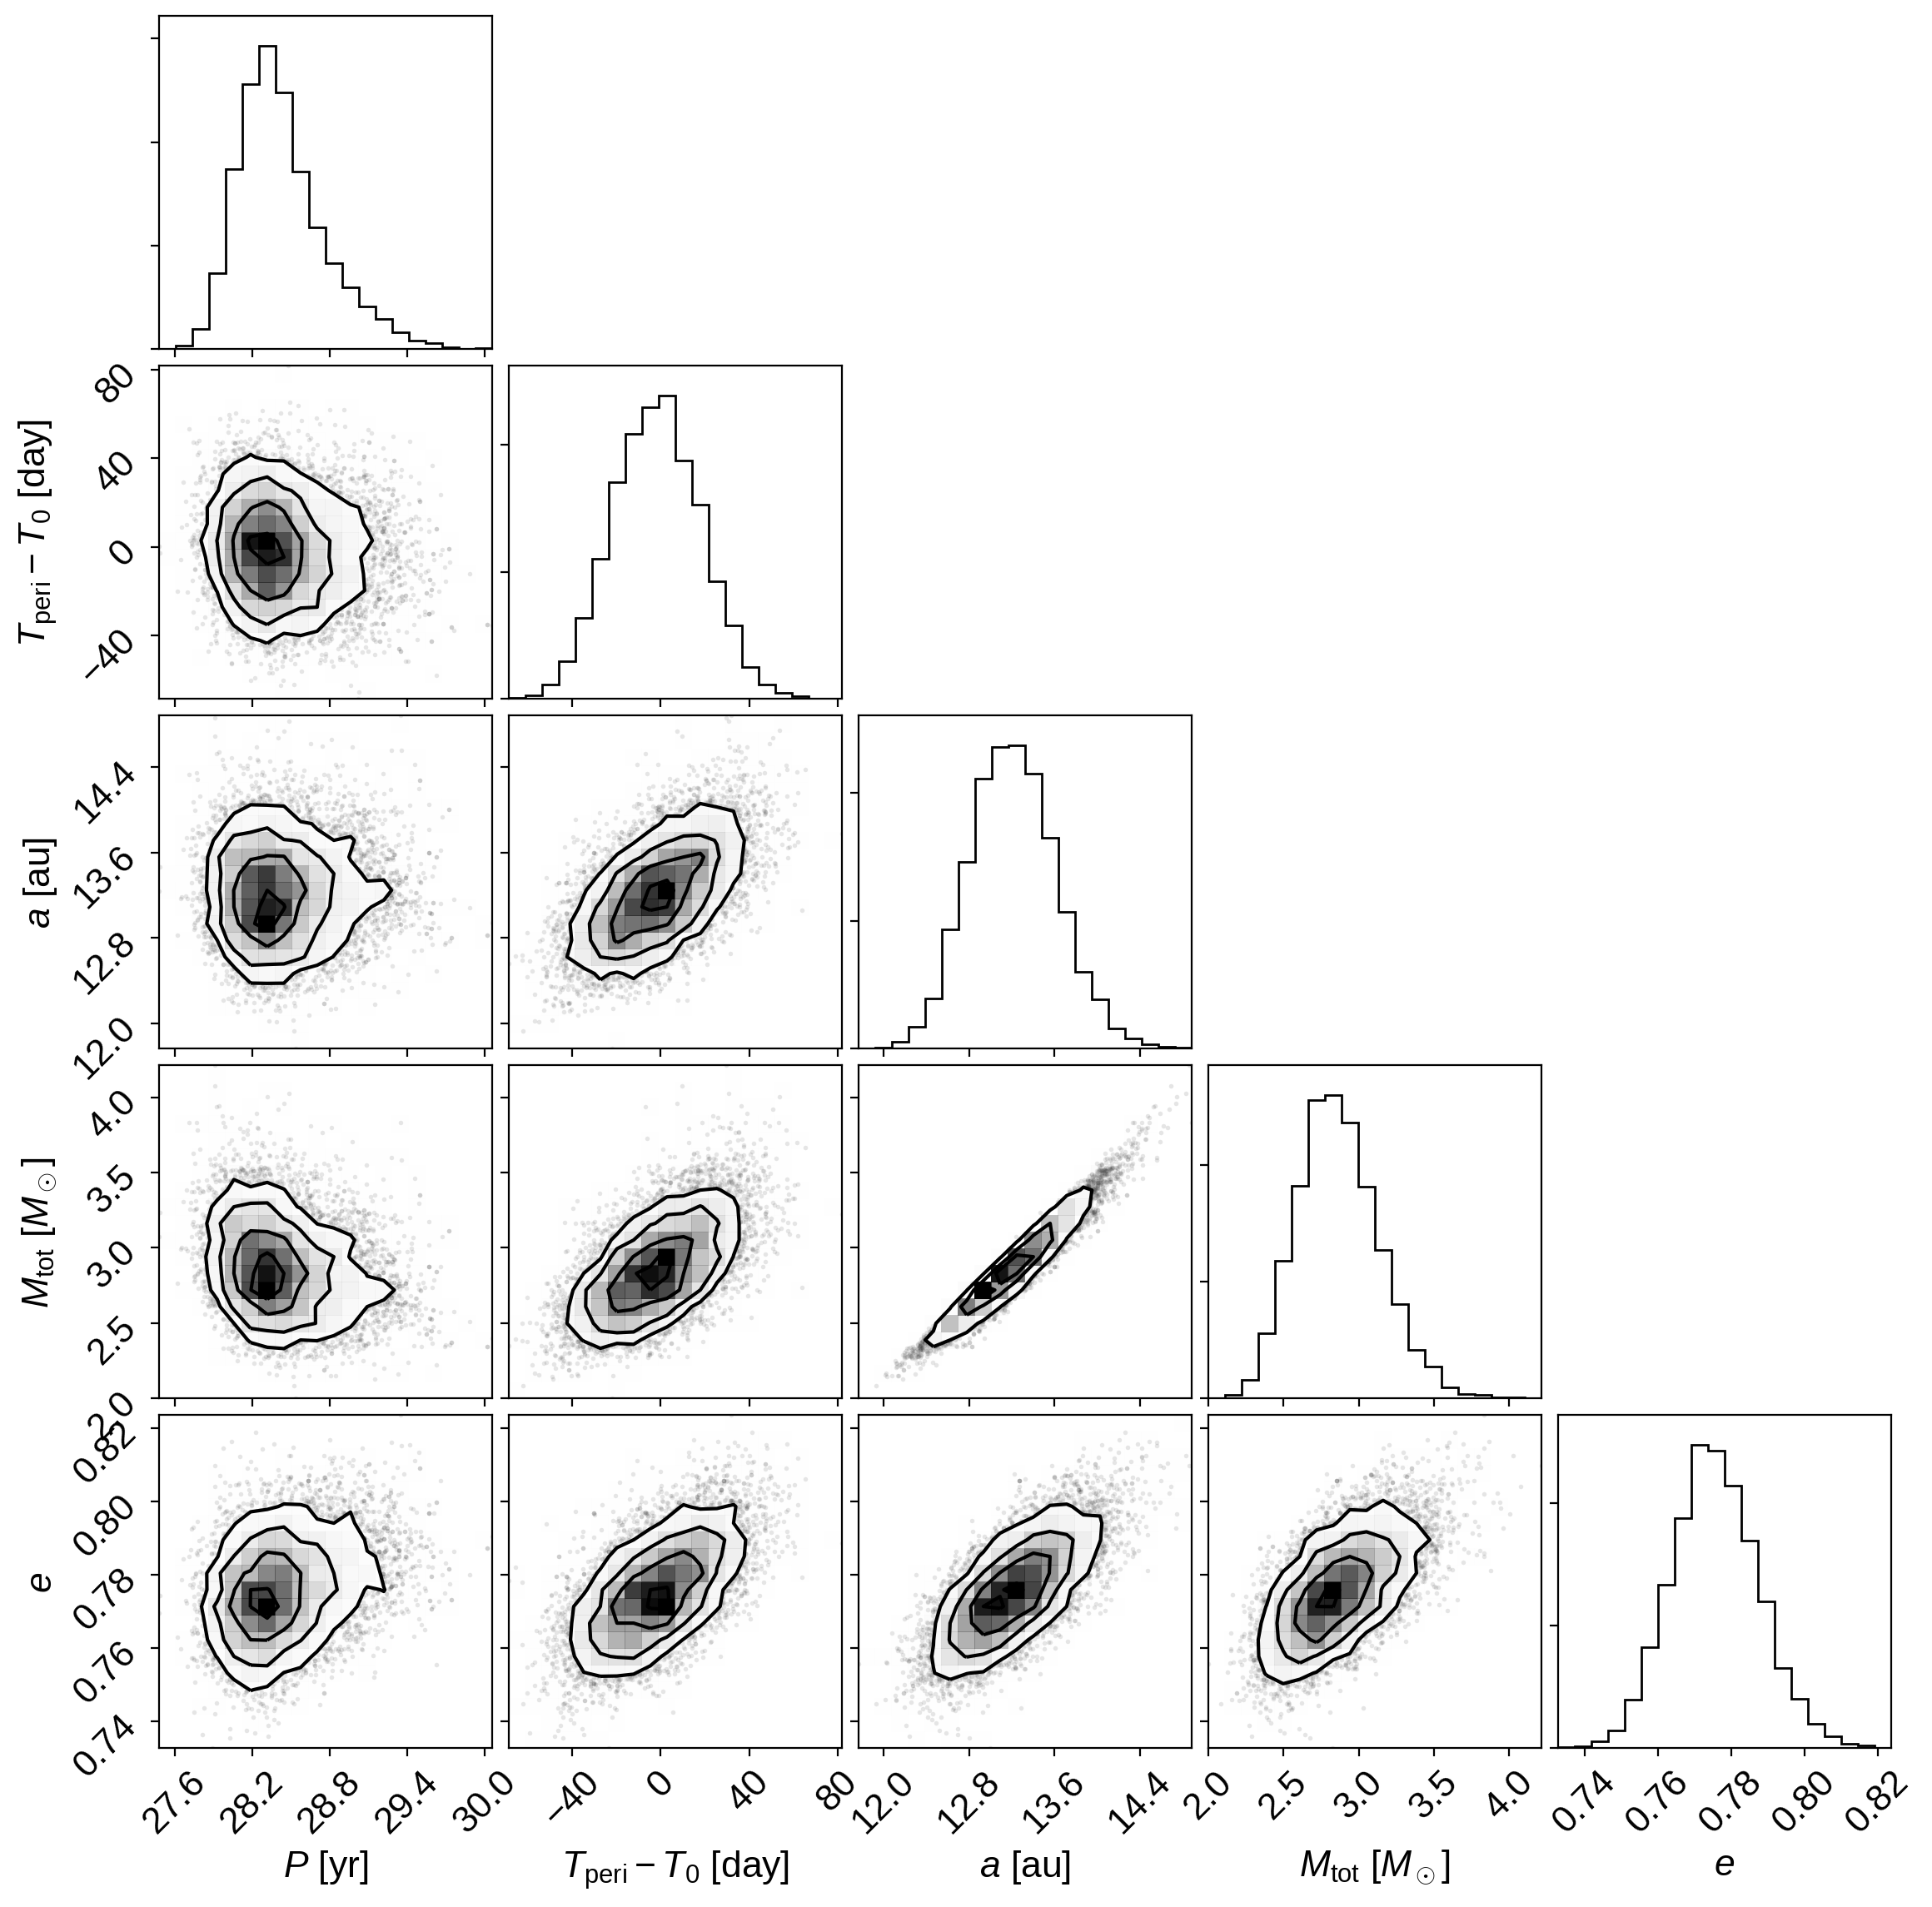

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.4},
   month = dec,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
